In [128]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import missingno as msno
import plotly.express as px
from scipy import stats 
from kneed import KneeLocator

from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import datetime as dt

## I- Chargement des données

In [129]:
df = pd.read_csv('df_customers.csv')
df.head()

customer_unique_id order_purchase_timestamp customer_state  \
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27             SP   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27             SP   
2  0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03             SC   
3  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41             PA   
4  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42             SP   

   order_id  nb_total_item   price  freight_value payment_type  \
0         1              1  129.90          12.00  credit_card   
1         1              1   18.90           8.29  credit_card   
2         1              1   69.00          17.22  credit_card   
3         1              1   25.99          17.63  credit_card   
4         1              1  180.00          16.89  credit_card   

   mean_payment_installments  total_payment_value  mean_payment_value  \
0                        8.0               141.90              141.90   
1                        1.0                27.19               27.19   
2                        8.0                86.22               86.22   
3                        4.0                43.62               43.62   
4                        6.0               196.89              196.89   

   mean_review_score seller_state product_category_name  
0                5.0           SP        bed_bath_table  
1                4.0           SP         health_beauty  
2                3.0           SP            stationery  
3                4.0           SP             telephony  
4                5.0           SP             telephony

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         91481 non-null  object 
 1   order_purchase_timestamp   91481 non-null  object 
 2   customer_state             91481 non-null  object 
 3   order_id                   91481 non-null  int64  
 4   nb_total_item              91481 non-null  int64  
 5   price                      91481 non-null  float64
 6   freight_value              91481 non-null  float64
 7   payment_type               91481 non-null  object 
 8   mean_payment_installments  91481 non-null  float64
 9   total_payment_value        91481 non-null  float64
 10  mean_payment_value         91481 non-null  float64
 11  mean_review_score          91481 non-null  float64
 12  seller_state               91481 non-null  object 
 13  product_category_name      91481 non-null  obj

In [131]:
df.describe()

order_id  nb_total_item         price  freight_value  \
count  91481.000000   91481.000000  91481.000000   91481.000000   
mean       1.032870       1.237525    148.338325      24.753683   
std        0.206215       0.844319    243.748770      27.071499   
min        1.000000       1.000000      0.850000       0.000000   
25%        1.000000       1.000000     48.900000      14.100000   
50%        1.000000       1.000000     89.900000      17.730000   
75%        1.000000       1.000000    159.900000      26.630000   
max       14.000000      75.000000  13440.000000    1794.960000   

       mean_payment_installments  total_payment_value  mean_payment_value  \
count               91481.000000         91481.000000        91481.000000   
mean                    2.903113           212.326244          157.720299   
std                     2.679754           631.282232          215.706278   
min                     0.000000             9.590000            1.856818   
25%                     1.000000            63.860000           60.750000   
50%                     2.000000           112.850000          103.470000   
75%                     4.000000           202.760000          174.990000   
max                    24.000000        109312.640000        13664.080000   

       mean_review_score  
count       91481.000000  
mean            4.154788  
std             1.279158  
min             1.000000  
25%             4.000000  
50%             5.000000  
75%             5.000000  
max             5.000000

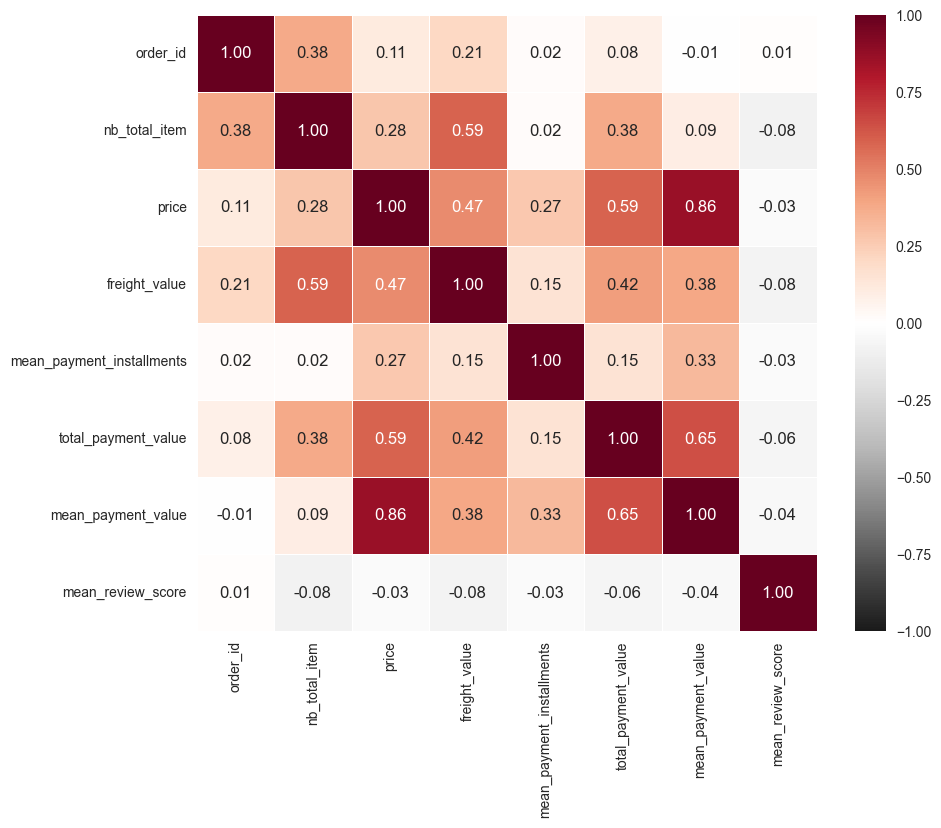

In [132]:
df_numerical = df.select_dtypes(include=['float64', 'int64'])
plt.subplots(figsize=(10, 8))
sns.heatmap(df_numerical.corr(), vmin=-1, vmax=1, linewidths=0.5, annot=True, fmt=".2f", cmap="RdGy_r")
plt.show()

## II- Segmentation RFM

### 2.1) Construction du df

La segmentation RFM prend en compte la **Récence** (date de la dernière commande), la **Fréquence** des commandes et le **Montant** (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes. Cette analyse permet de prédire le comportement d'un nouveau client à partir du comportement de nos clients présents dans notre base de données.

In [133]:
# Calcul de la fréquence (F) en SQL
rfm_frequency_query = """
SELECT 
    customer_unique_id,
    order_id AS frequency
FROM df
GROUP BY customer_unique_id
"""

In [134]:
rfm_frequency = sqldf(rfm_frequency_query, globals())

In [135]:
# Calcul du montant (M) en SQL
rfm_monetary_query = """
SELECT 
    customer_unique_id,
    SUM(price + freight_value) AS monetary
FROM df
GROUP BY customer_unique_id
"""

In [136]:
rfm_monetary = sqldf(rfm_monetary_query, globals())
rfm = pd.merge(rfm_frequency, rfm_monetary, on='customer_unique_id')

In [137]:
# Calcul de la récence (R) 
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
date_reference = df['order_purchase_timestamp'].max()
recency = (date_reference - df.groupby('customer_unique_id')['order_purchase_timestamp'].max()).dt.days
recency = recency.reset_index()
recency.columns = ['customer_unique_id', 'recency']

In [138]:
# Fusionner les données RFM (Récence, Fréquence, Montant) en un seul DataFrame pour chaque client
rfm = pd.merge(recency, rfm, on='customer_unique_id')

In [139]:
rfm.describe()

recency     frequency      monetary
count  91481.000000  91481.000000  91481.000000
mean     236.108875      1.032870    173.092009
std      152.586572      0.206215    257.592652
min        0.000000      1.000000     10.070000
25%      113.000000      1.000000     64.000000
50%      217.000000      1.000000    110.170000
75%      344.000000      1.000000    188.500000
max      694.000000     14.000000  13664.080000

In [140]:
# Calcul des quantiles pour chaque colonne individuellement
recency_quantiles = rfm['recency'].quantile(q=[0.25, 0.5, 0.75])
frequency_quantiles = rfm['frequency'].quantile(q=[0.25, 0.5, 0.75])
monetary_quantiles = rfm['monetary'].quantile(q=[0.25, 0.5, 0.75])

print("Recency Quantiles:")
print(recency_quantiles)
print("\nFrequency Quantiles:")
print(frequency_quantiles)
print("\nMonetary Quantiles:")
print(monetary_quantiles)

Recency Quantiles:
0.25    113.0
0.50    217.0
0.75    344.0
Name: recency, dtype: float64

Frequency Quantiles:
0.25    1.0
0.50    1.0
0.75    1.0
Name: frequency, dtype: float64

Monetary Quantiles:
0.25     64.00
0.50    110.17
0.75    188.50
Name: monetary, dtype: float64


In [141]:
quantiles = {
    'recency': recency_quantiles.to_dict(),
    'frequency': frequency_quantiles.to_dict(),
    'monetary': monetary_quantiles.to_dict()
}

In [142]:
def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Appliquer les scores RFM
rfm['R'] = rfm['recency'].apply(rfm_score, args=('recency', quantiles,))
rfm['F'] = rfm['frequency'].apply(rfm_score, args=('frequency', quantiles,))
rfm['M'] = rfm['monetary'].apply(rfm_score, args=('monetary', quantiles,))

In [143]:
# Score RFM total
rfm['RFM_score'] = rfm['R'] + rfm['F'] + rfm['M']
rfm.head()

customer_unique_id  recency  frequency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90  4  4  2   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19  3  4  4   
2  0000f46a3911fa3c0805444483337064      536          1     86.22  1  4  3   
3  0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62  2  4  4   
4  0004aac84e0df4da2b147fca70cf8255      287          1    196.89  2  4  1   

   RFM_score  
0         10  
1         11  
2          8  
3         10  
4          7

In [144]:
rfm.describe()

recency     frequency      monetary             R             F  \
count  91481.000000  91481.000000  91481.000000  91481.000000  91481.000000   
mean     236.108875      1.032870    173.092009      2.504815      3.911227   
std      152.586572      0.206215    257.592652      1.120857      0.508370   
min        0.000000      1.000000     10.070000      1.000000      1.000000   
25%      113.000000      1.000000     64.000000      2.000000      4.000000   
50%      217.000000      1.000000    110.170000      3.000000      4.000000   
75%      344.000000      1.000000    188.500000      4.000000      4.000000   
max      694.000000     14.000000  13664.080000      4.000000      4.000000   

                  M     RFM_score  
count  91481.000000  91481.000000  
mean       2.500661      8.916704  
std        1.118573      1.704021  
min        1.000000      3.000000  
25%        2.000000      8.000000  
50%        3.000000      9.000000  
75%        4.000000     10.000000  
max        4.000000     12.000000

In [145]:
# Seuils pour chaque segment
champions = 12  
loyal = 10 
loyalistes_potentiels = 8
a_reactiver = 6  
perdus = 4 
a_risque = 3 
recent = 2 
en_sommeil = 1  

In [146]:
def segmenter_rfm(score):
    if score >= champions:
        return 'Champions'
    elif score >= loyal:
        return 'Loyaux'
    elif score >= loyalistes_potentiels:
        return 'Loyalistes potentiels'
    elif score >= a_reactiver:
        return 'À réactiver'
    elif score >= perdus:
        return 'Perdus'
    elif score >= a_risque:
        return 'À risque'
    elif score >= recent:
        return 'Récent'
    elif score >= en_sommeil:
        return 'En sommeil'
    else:
        return 'Prometteurs'

rfm['Segment'] = rfm['RFM_score'].apply(segmenter_rfm)
rfm.head()

customer_unique_id  recency  frequency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90  4  4  2   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19  3  4  4   
2  0000f46a3911fa3c0805444483337064      536          1     86.22  1  4  3   
3  0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62  2  4  4   
4  0004aac84e0df4da2b147fca70cf8255      287          1    196.89  2  4  1   

   RFM_score                Segment  
0         10                 Loyaux  
1         11                 Loyaux  
2          8  Loyalistes potentiels  
3         10                 Loyaux  
4          7            À réactiver

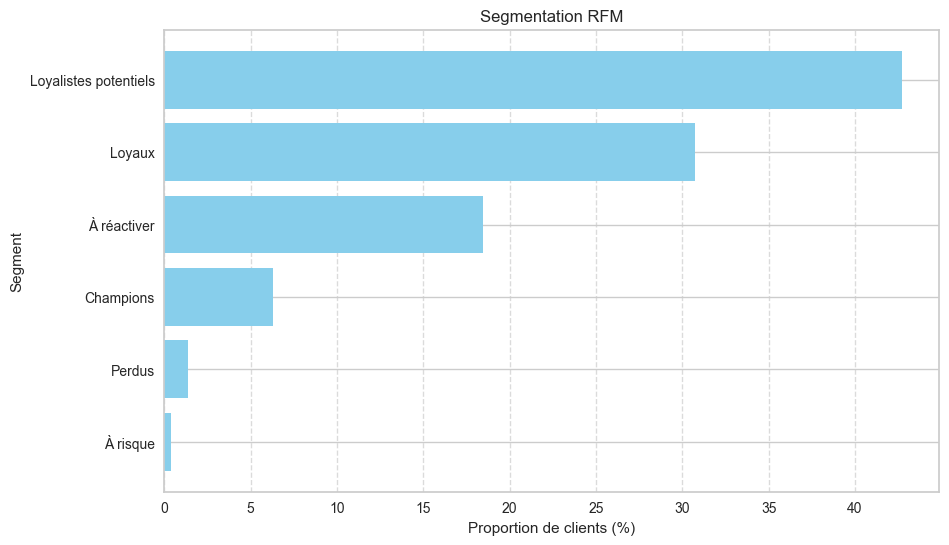

In [147]:
segment_counts = rfm['Segment'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
plt.barh(segment_counts.index, segment_counts.values, color='skyblue')
plt.xlabel('Proportion de clients (%)')
plt.ylabel('Segment')
plt.title('Segmentation RFM')
plt.gca().invert_yaxis()  # Inverser l'ordre des segments
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

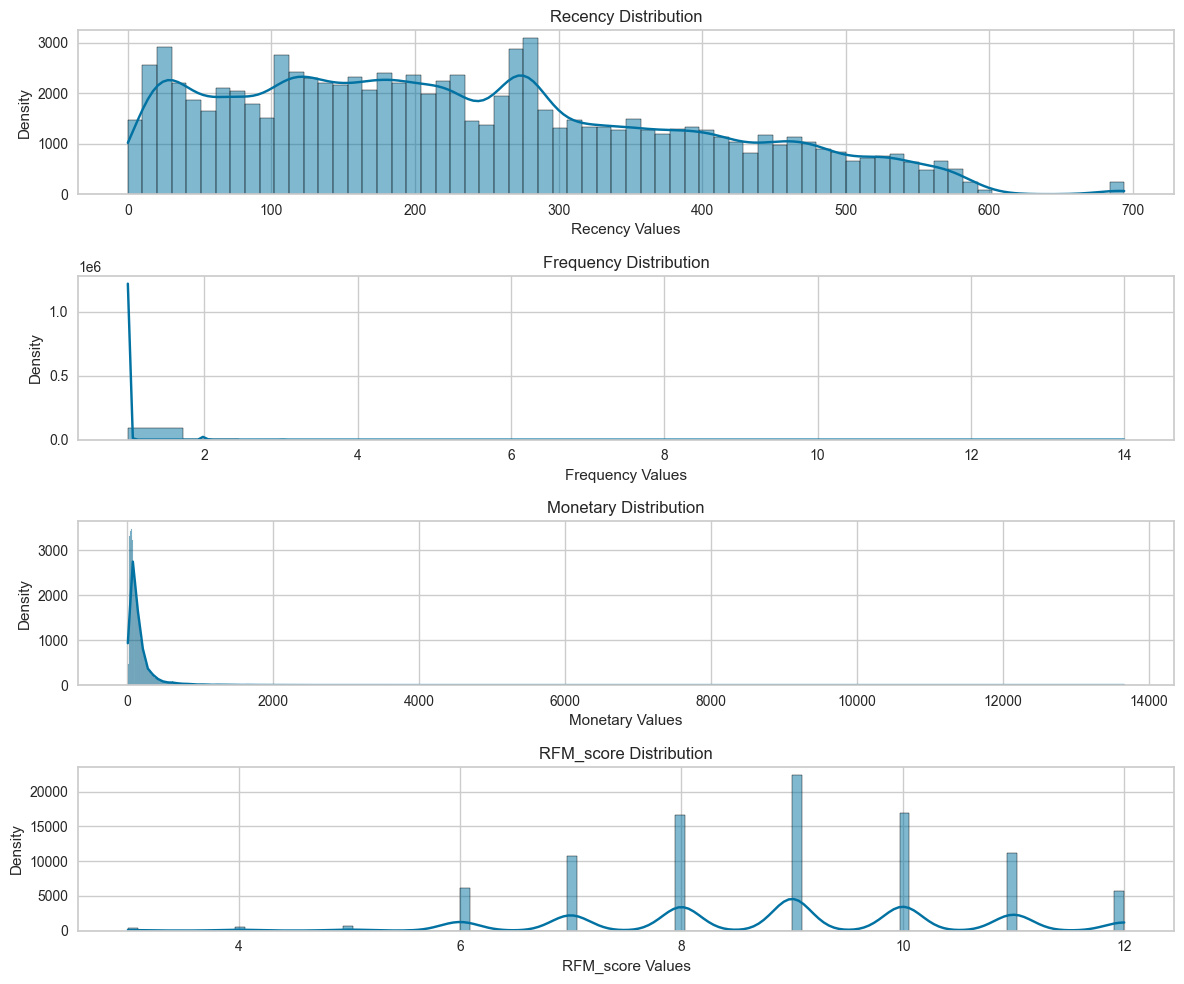

In [148]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
sns.histplot(rfm['recency'], kde=True)
plt.title('Recency Distribution')
plt.xlabel('Recency Values')
plt.ylabel('Density')

plt.subplot(4, 1, 2)
sns.histplot(rfm['frequency'], kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency Values')
plt.ylabel('Density')

plt.subplot(4, 1, 3)
sns.histplot(rfm['monetary'], kde=True)
plt.title('Monetary Distribution')
plt.xlabel('Monetary Values')
plt.ylabel('Density')

plt.subplot(4, 1, 4)
sns.histplot(rfm['RFM_score'], kde=True)
plt.title('RFM_score Distribution')
plt.xlabel('RFM_score Values')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


## 2.2) Algorithme du K-means 

K-Means est un algorithme simple d'apprentissage automatique non supervisé qui regroupe les données dans K clusters, où K est spécifié par l'utilisateur, même si ce nombre peut ne pas être optimal pour l'ensemble de données. L'algorithme K-Means cherche à partitionner les données de manière à minimiser la variance intra-cluster.

Pour déterminer le nombre optimal de clusters, différents critères peuvent être utilisés, notamment :

- **La distorsion** : la somme des distances au carré entre chaque point de données et son centre de cluster attribué.
- **Le coefficient de silhouette** : une mesure de la similarité des points à l'intérieur de leur cluster par rapport à d'autres clusters. Il est calculé comme la différence entre la distance moyenne intra-cluster et la distance moyenne au cluster le plus proche, le tout normalisé.
- **L'indice de Calinski-Harabasz** : il évalue la qualité de la partition en mesurant le rapport de dispersion entre et à l'intérieur des clusters.

Ces métriques aident à choisir le nombre optimal de clusters pour un ensemble de données donné lors de l'utilisation de l'algorithme K-Means.
K-Means

In [149]:
# Normalisation des données
X = rfm[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2.2.1) KElbowVisualizer

KElbowVisualizer de Yellowbrick implémente la méthode du "coude" pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une gamme de valeurs pour K. Si le graphique linéaire ressemble à un bras, le "coude" (le point d'inflexion de la courbe) est une bonne indication que le modèle sous-jacent s'ajuste le mieux à ce point. Il permet ainsi de déterminer un paramètre K optimal dans la métrique de clustering.

La métrique par défaut est fixé sur la distorsion, calculant la somme des distances au carré entre chaque point et le centroide. Nous choisissons plutôt la métrique 'silhouette'. Contrairement à la distortion et à la métrique de Clinski-Harabasz, qui se concentrent uniquement sur la cohésion intra-cluster, la silhouette offre une vue plus équilibrée de la qualité des clusters en tenant compte également de la séparation entre les clusters. Elle permet donc une compréhension plus détaillée de la structure des clusters formés.

In [150]:
def elbow_visualizer(kmin, kmax, data, metric):
    '''Affiche le KElbowVisualizer pour k allant
    de k_min à k_max et selon la métrique indiquée:
        kmin : le k minimal à calculer 
        kmax : le k maximal à calculer
        data : le dataframe
        metric : la métrique à calculer 
    '''
    model = KMeans(random_state=0, n_init=10)
    elbow_vis = KElbowVisualizer(model, k=(kmin, kmax), metric=metric)
    elbow_vis.fit(data)
    elbow_vis.show()
    return elbow_vis

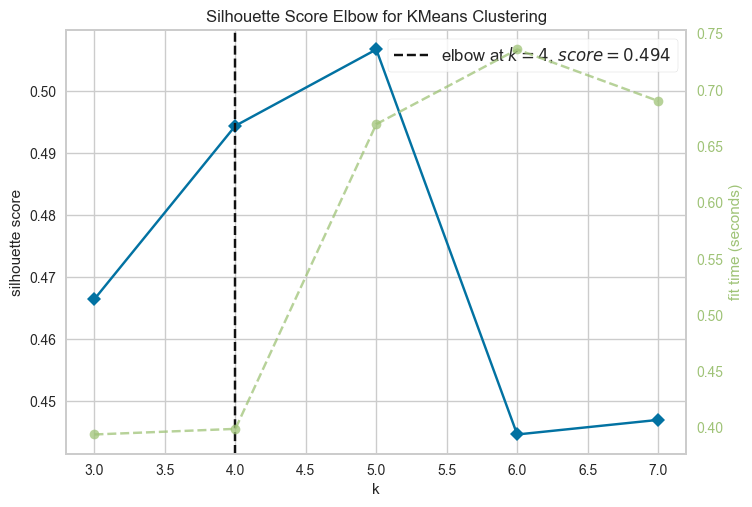

In [151]:
rfm_kmean = elbow_visualizer(3, 8, X_scaled, 'silhouette')

In [152]:
result_rfm_kmeans = pd.DataFrame(data={'k': np.arange(3, 8),
                                      'sil_scores': rfm_kmean.k_scores_,
                                      'temps': rfm_kmean.k_timers_})

result_rfm_kmeans

k  sil_scores     temps
0  3    0.466489  0.393994
1  4    0.494458  0.398970
2  5    0.506776  0.669623
3  6    0.444635  0.735981
4  7    0.446988  0.690268

Cette méthode nous indique que la segmentation en 4 clusters (k=4) semble être la plus pertinente.

### 2.2.2) SilhouetteVisualizer

SilhouetteVisualizer évalue la densité et la séparation entre les cluster. Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui correspond à la différence entre la distance moyenne intra-cluster et la distance moyenne entre les cluster les plus proches pour chaque échantillon, normalisée par la valeur maximale. Il en résulte un score compris entre -1 et +1, où les scores proches de +1 indiquent une forte séparation et les scores proches de -1 indiquent que les échantillons peuvent avoir été assignés au mauvais groupe.

Le SilhouetteVisualizer affiche le coefficient de silhouette pour chaque échantillon par cluster, ce qui permet aux utilisateurs de visualiser la densité et la séparation des cluster. Il est particulièrement utile pour déterminer le déséquilibre des cluster ou pour sélectionner une valeur pour K en comparant plusieurs visualiseurs.

In [153]:
k_selected = rfm_kmean.elbow_value_
k_selected

4

In [154]:
def silhouette_visualizer(k, data):
    '''Affiche le silhouette vizualiser.
    k : le nombre de cluster choisi 
    X : le dataframe
    '''
    plt.figure(figsize=(10, 10))
    model = KMeans(k, random_state=0, n_init=10)
    silhouette_vis = SilhouetteVisualizer(model)

    silhouette_vis.fit(data)
    silhouette_vis.show()

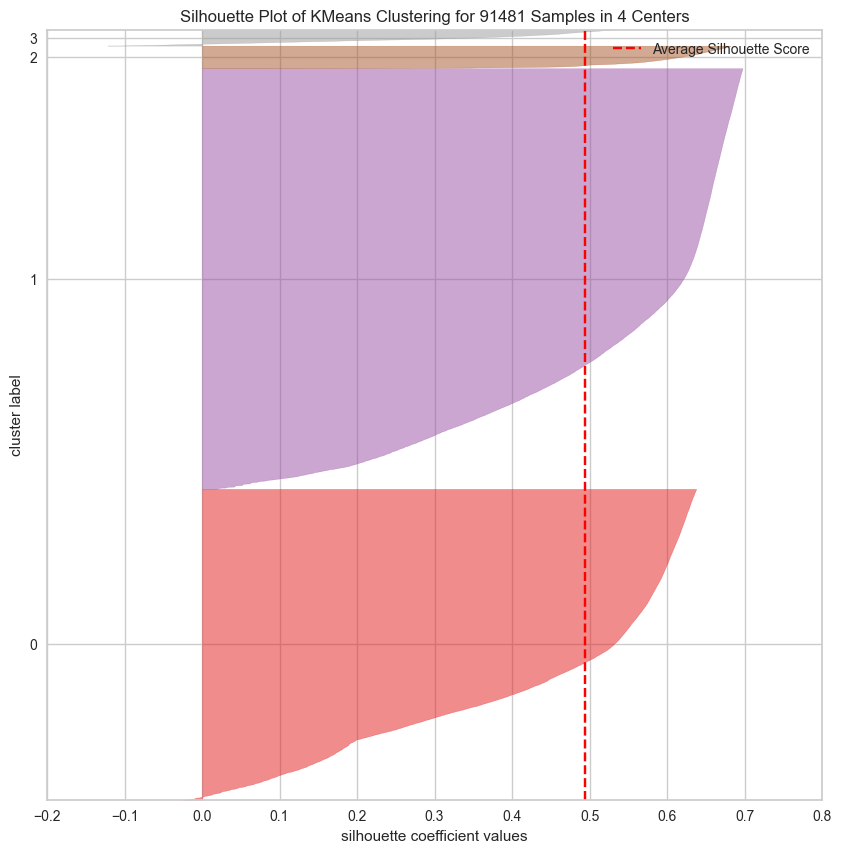

In [155]:
silhouette_visualizer(k_selected, X_scaled)

On constate que les deux premiers clusters sont très larges, alors que les deux autres sont très fins. La largeur de chaque silhouette est proportionnelle au nombre d'échantillons affectés au cluster. Les silhouettes score sont positifs, ce qui signifie qu'aucune erreur n'a été effectuée sauf pour le cluster 4. Le silhouette score moyen se situe près de 0.5.

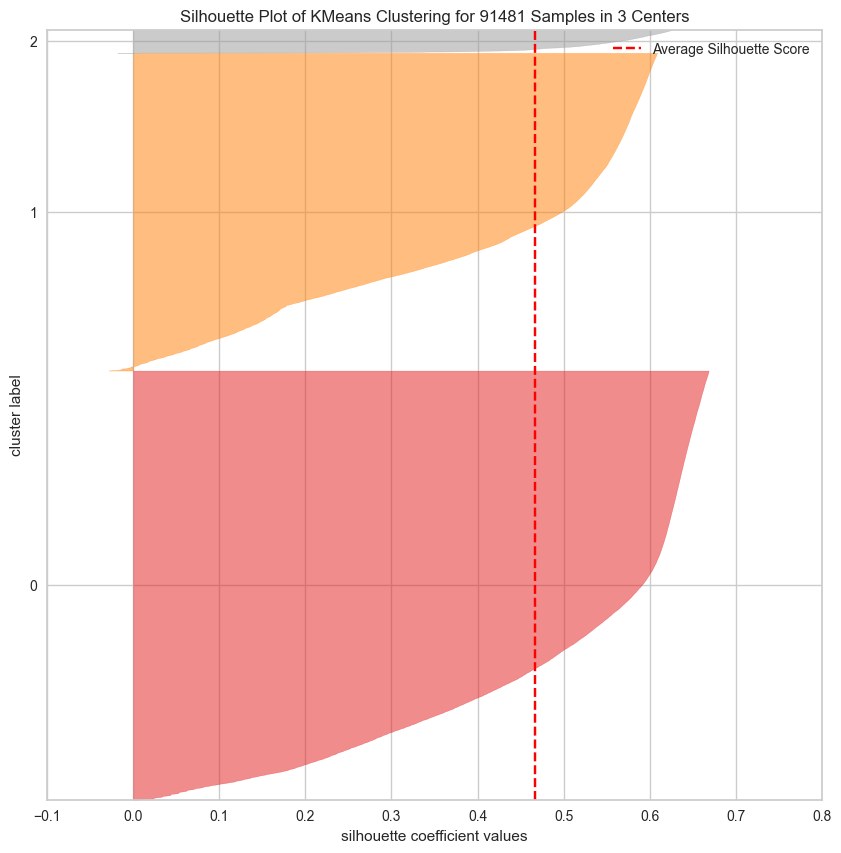

In [156]:
silhouette_visualizer(3, X_scaled)

On constate que les deux premiers clusters sont très larges, alors que le dernier est très fin. On note aussi des silhouettes score positifs mais aussi négatifs, ce indiquent que les échantillons ont peut-être été affectés au mauvais cluster. Le silhouette score moyen se situe près de 0.47.

### 2.2.3) Distance inter-cluster

In [157]:
def distance_visualizer(k, X):
    '''Affiche la distance entre les k cluster.
    k : le nombre de cluster choisi 
    X : le dataframe
    '''
    distance_vis = InterclusterDistance(KMeans(k, random_state=0, n_init=10))
    distance_vis.fit(X_scaled)
    distance_vis.show()

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


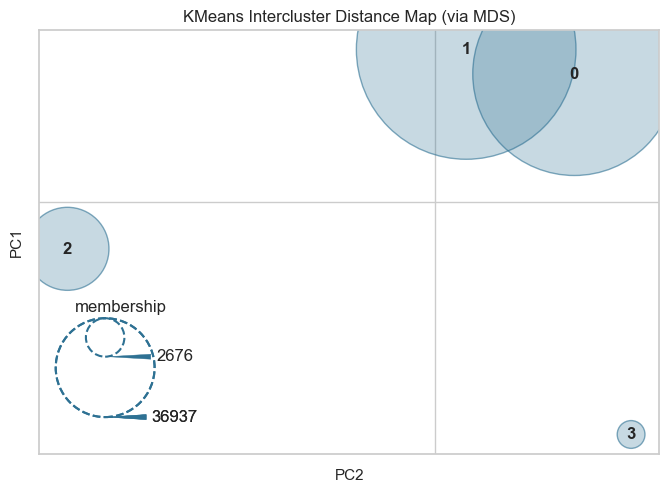

In [158]:
distance_visualizer(k_selected, X_scaled)

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


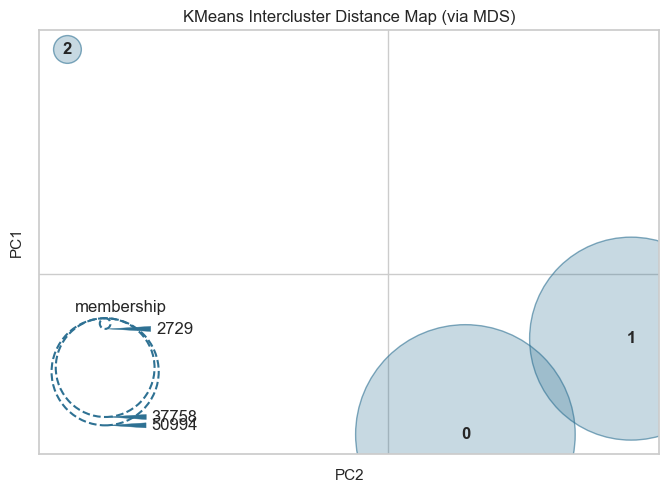

In [159]:
distance_visualizer(3, X_scaled)

On constate que pour k=4, les deux premiers cluster se chevauchent alors que les deux autres clusters sont bien séparés. Il faut cependant noter que des clusters qui se chevauchent dans l'espace 2D, n'implique pas qu'ils se chevauchent dans l'espace des caractéristiques d'origine.

Pour k=3, les clusters semblent bien séparés

### 2.2.4) Analyse des clusters

In [160]:
def kmeans_analysis(df, k_selected, features=['recency', 'frequency', 'monetary']):
    X_scaled = df[features].values
    
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    
    # Entraînement du modèle 
    kmeans = KMeans(n_clusters=k_selected, random_state=0, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Affichage du nombre de clients par cluster
    cluster_counts = df['cluster'].value_counts().sort_index()
    print("Nombre de clients par cluster :")
    print(cluster_counts)
        
    # Histogramme du nombre de clients par cluster
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title('Nombre de clients par cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Nombre de clients')
    plt.show()
        
    # Distribution des features pour chaque cluster
    for feature in features:
        plt.figure(figsize=(10, 6))
        for cluster in range(k_selected):
            plt.hist(df[df['cluster'] == cluster][feature], bins=20, alpha=0.5, label=f'Cluster {cluster}')
        plt.title(f'Distribution de {feature} par cluster')
        plt.xlabel(feature)
        plt.ylabel('Nombre de clients')
        plt.legend()
        plt.show()
        
    # Radar Chart
    cluster_centers = kmeans.cluster_centers_
    num_clusters = cluster_centers.shape[0]
    num_features = cluster_centers.shape[1]

    eps = 1e-10
    cluster_centers += eps
    cluster_centers = np.concatenate((cluster_centers, cluster_centers[:, [0]]), axis=1)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for i in range(num_clusters):
        values = cluster_centers[i].tolist()
        angles_with_duplicate = angles + [angles[0]] 
        ax.plot(angles_with_duplicate, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles_with_duplicate, values, alpha=0.1)

    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels([f'Feature {i+1}' for i in range(num_features)])  

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Radar Chart des clusters')
    plt.show()

    # PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    # 3D Scatterplot
    fig = plt.figure(figsize=(15, 10))
    
    # Scatterplot des variables originales
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(df['recency'], df['frequency'], df['monetary'], c=df['cluster'], cmap=plt.cm.Set2)
    ax1.set_xlabel('recency')
    ax1.set_ylabel('frequency')
    ax1.set_zlabel('monetary')
    ax1.set_title('Scatterplot des variables originales avec clusters')

    # Scatterplot des composantes principales
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df['cluster'], cmap=plt.cm.Set2)
    ax2.legend(*scatter.legend_elements())
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.set_title(f'PCA et clustering RFM avec Kmeans k={k_selected}')

    plt.show()

Nombre de clients par cluster :
cluster
0    49264
1      464
2    36476
3     5277
Name: count, dtype: int64


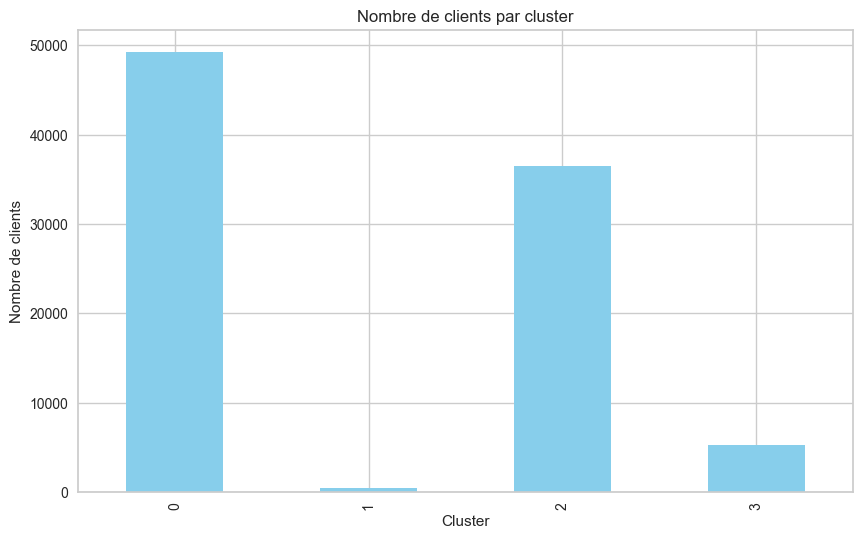

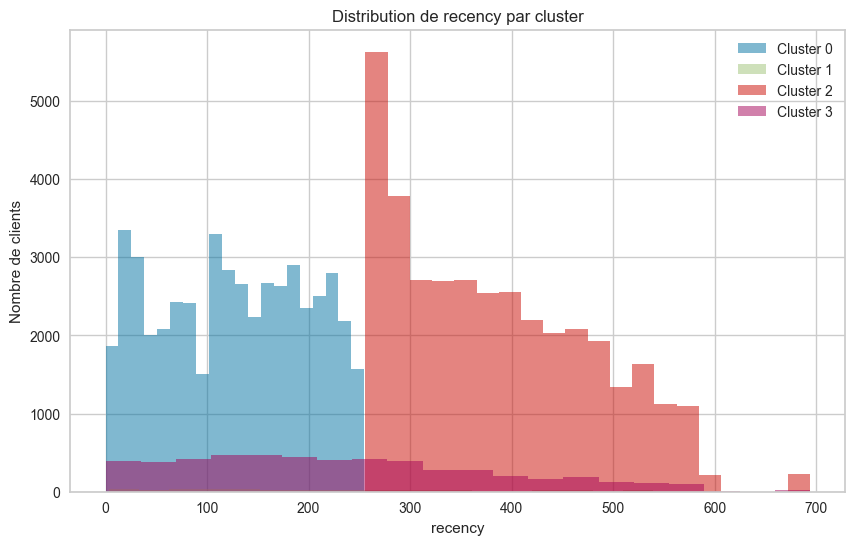

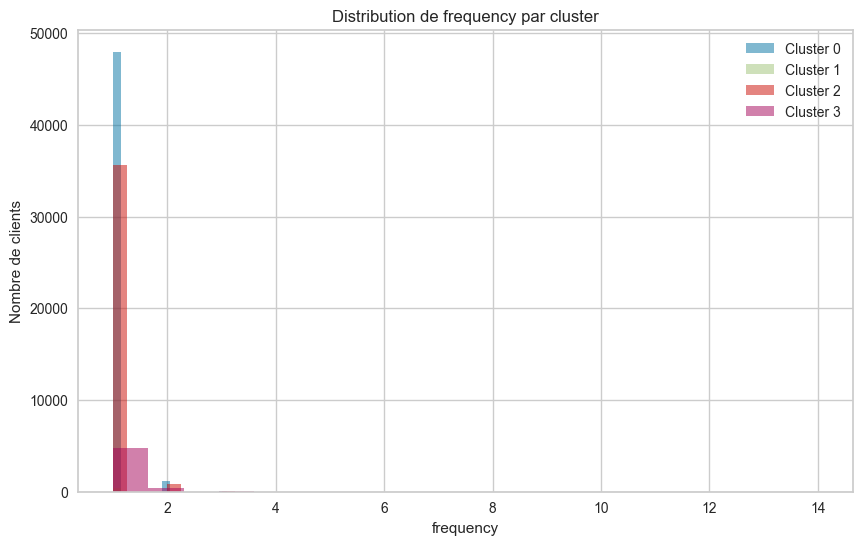

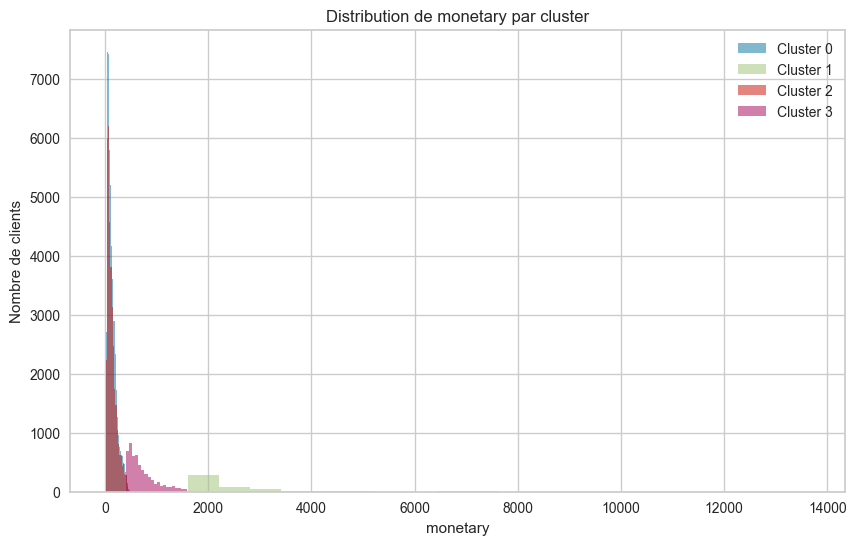

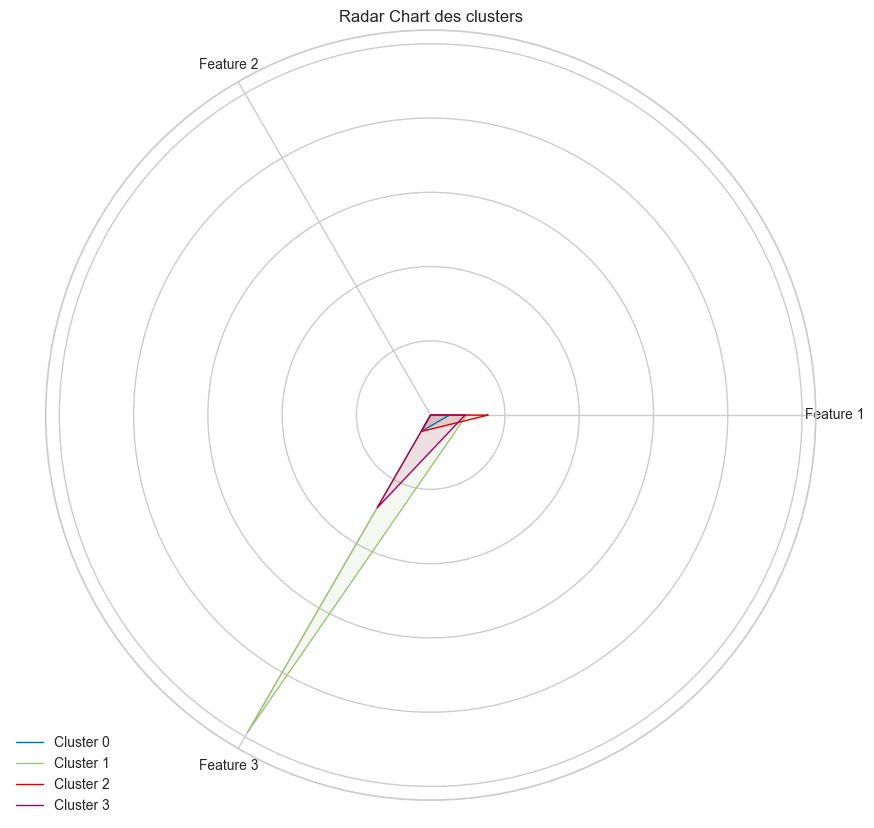

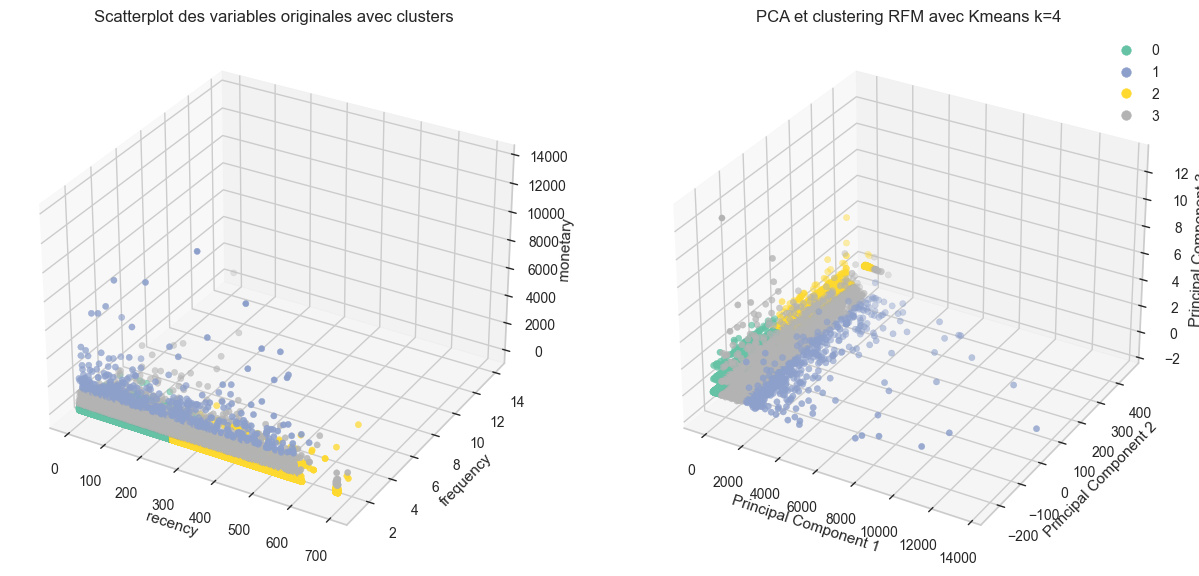

In [161]:
kmeans_analysis(rfm, k_selected)

Nombre de clients par cluster :
cluster
0    51208
1     2503
2    37770
Name: count, dtype: int64


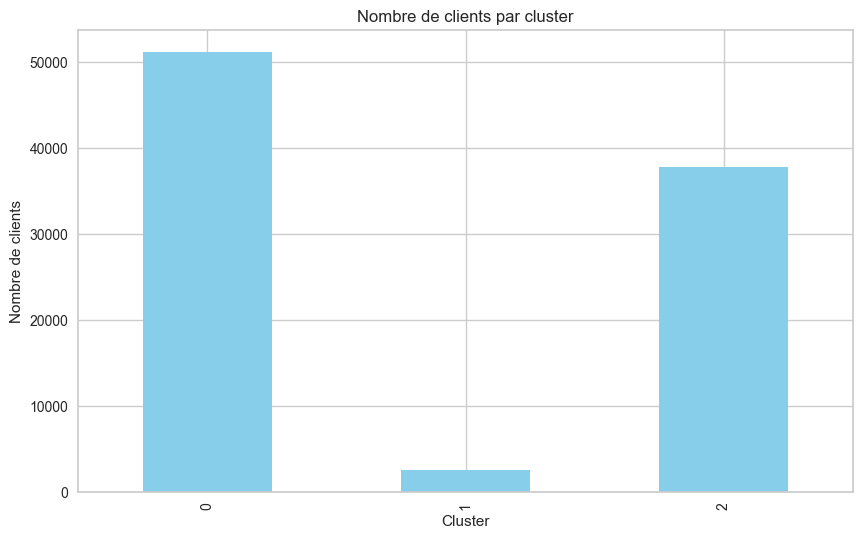

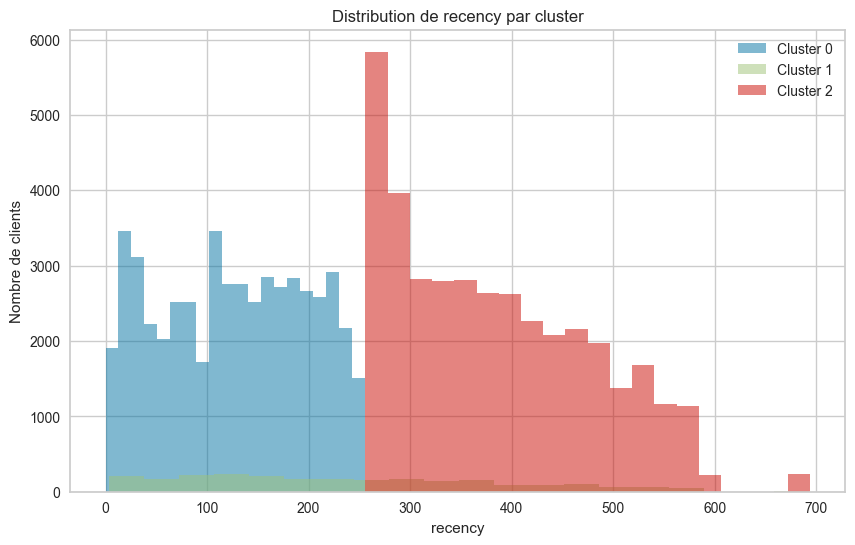

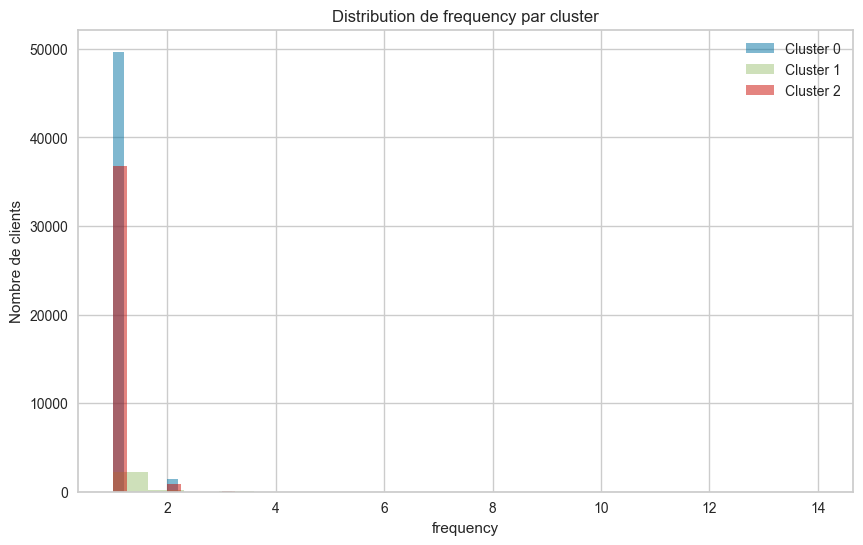

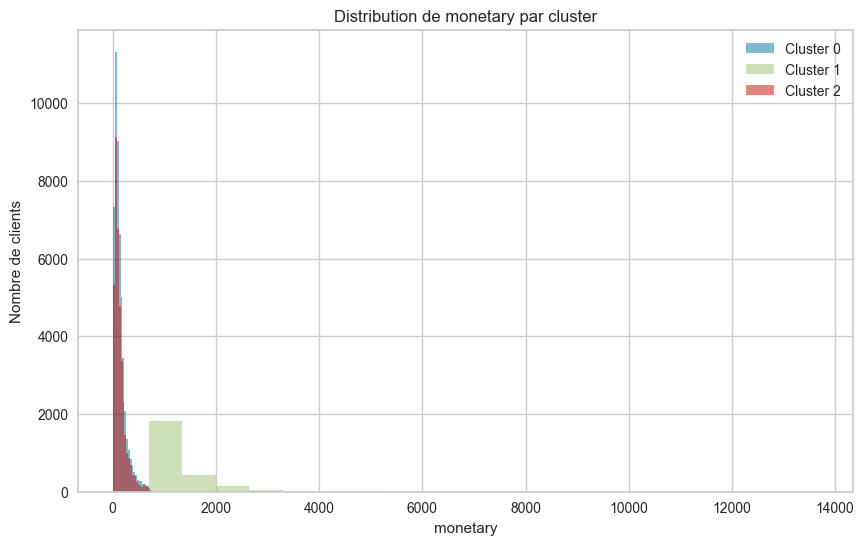

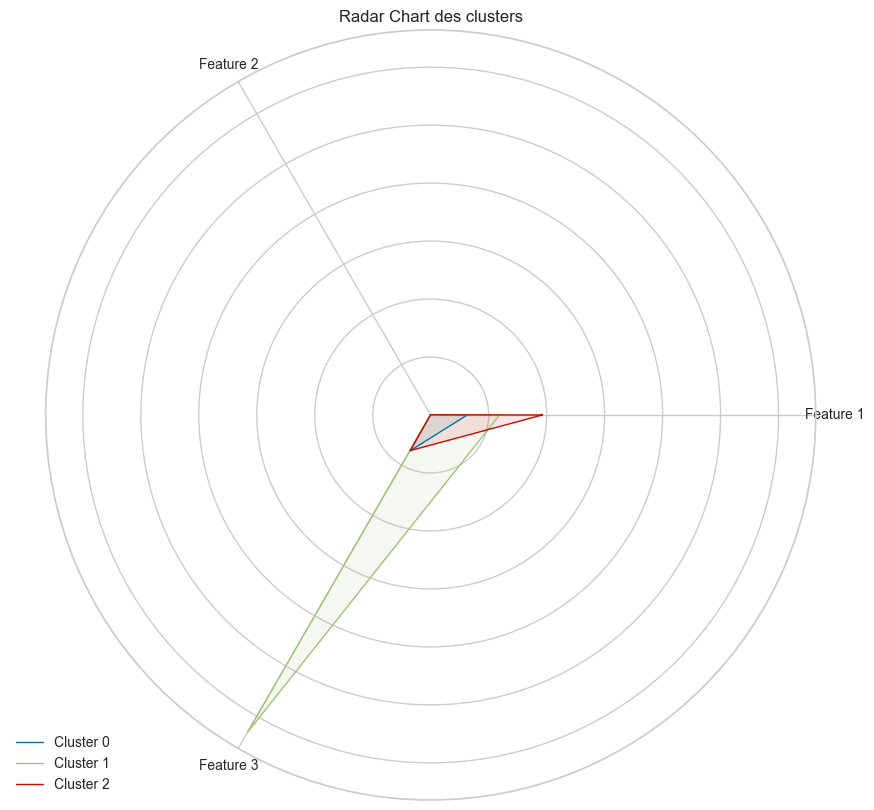

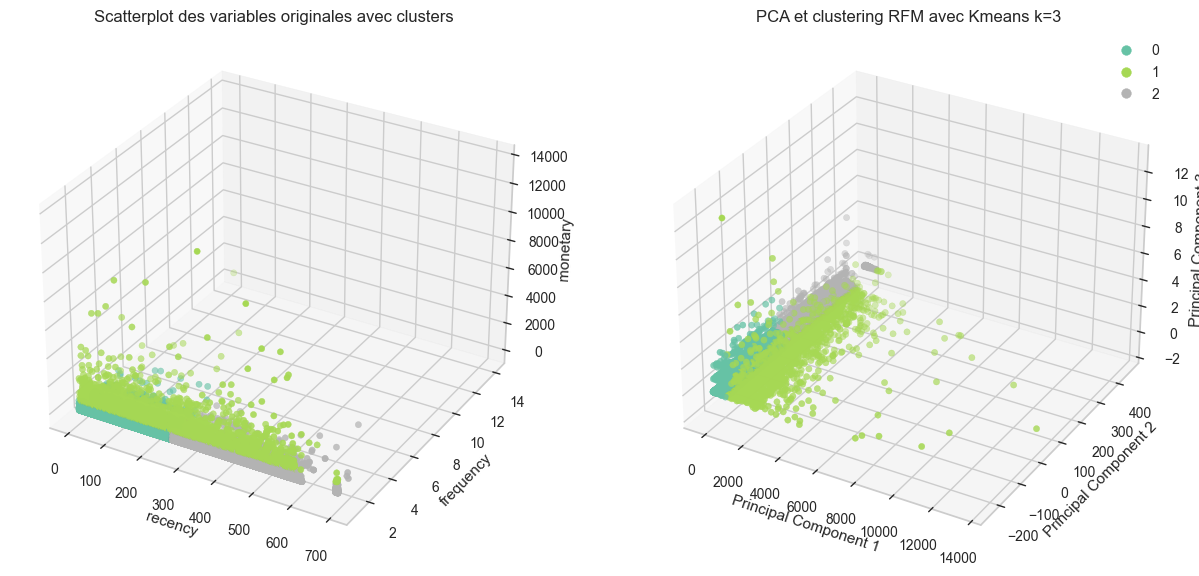

In [162]:
kmeans_analysis(rfm, 3)

Les différentes représentations nous permettent de voir que le clustering (k=4) effectué semble opposer les clients selon leur récence et le montant de leurs commandes :

- **Cluster 0 :** Clients ayant commandé récemment, souvent pour la première fois, pour des montants faible.

- **Cluster 1 :** Clients ayant effectué des achats pour des sommes très élevées. Toutefois, il est important de noter que ce cluster présente un échantillon très réduit par rapport aux autes.

- **Cluster 2 :** Clients ayant effectué des achats il y a plus longtemps, généralement une seule fois, et pour des montants fables.

- **Cluster 3 :** Clients ayant commandé à la fois récemment et il y a longtemps. La plupart du temps, ils n'ont réalisé qu'une seule commande et pour des montants moyens.

Nous avons cherché à déterminer si la division en 3 clusters permettrait une meilleure interprétation des données. Voici ce que nous avons obtenu :

- **Cluster 0 :** Clients ayant commandé récemment, souvent pour la première fois, ponur des montats faibles.

- **Cluster 1 :** Clients ayant commandé à la fois récemment et il y a longtemps. La plupart du temps, ils n'ont réalisé qu'une seule commande. Cependant, ils correspondent aux clients ayant passé les commandes avec les montants le plus élevés.

- **Cluster 2 :** Clients ayant effectué des achats il y a plus longtemps, généralement une seule fois, et pour des montants faibles.

Bien que k=3 semble moins performant, il permet une meilleure interprétation des données. Nous conservons donc k=3.


### 2.3) DBSCAN

L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) itère sur les points du jeu de données. Pour chacun des points qu'il analyse, il construit l'ensemble des points atteignables par densité depuis ce point : il calcule l'epsilon-voisinage de ce point, puis, si ce voisinage contient plus de n_min points, les epsilon-voisinages de chacun d'entre eux, et ainsi de suite, jusqu'à ne plus pouvoir agrandir le cluster. Si le point considéré n'est pas un point intérieur, c'est-à-dire qu'il n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes, puisque ce mécanisme les isole.

In [163]:
def dbscan_param_selection(data, eps_range, min_samples):
    """
    Sélectionne des paramètres optimaux pour DBSCAN en utilisant la méthode du coude sur les distances des plus proches voisins.
    data : données à clusteriser.
    eps_range : plage de valeurs à tester pour eps.
    min_samples : nombre d'échantillons (ou plus) dans un voisinage pour être considéré comme un point central.
    """
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    dist = distances[:, 1]
    
    kneedle = KneeLocator(x=range(1, len(distances)+1), y=dist, S=10, curve="convex", direction="increasing", online=True)
    optimal_eps = kneedle.knee_y
    print('optimal_eps : ' + str(optimal_eps))
    
    for eps in eps_range:
        db_rfm_es = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        db_rfm_es.fit(data)
        db_lab_es = db_rfm_es.labels_

        print('Paramètres du modèle : epsilon : {}, min_samples : {}'.format(eps, min_samples))
        print('Nombre de clusters avec le modèle DBSCAN : ', len(set(db_lab_es)) - (1 if -1 in db_lab_es else 0))
        print('Nombre de points considérés comme du bruit: ', list(db_lab_es).count(-1))
        print('Silhouette Score : ', silhouette_score(data, db_lab_es))
        print('-----'*10)

**Avec min_samples = 100**

In [164]:
eps_range = [0.06, 0.07, 0.08, 0.09, 0.1]
min_samples = 100
dbscan_param_selection(X_scaled, eps_range, min_samples)

optimal_eps : 0.06255891875772175
Paramètres du modèle : epsilon : 0.06, min_samples : 100
Nombre de clusters avec le modèle DBSCAN :  3
Nombre de points considérés comme du bruit:  16680
Silhouette Score :  -0.1308498775947771
--------------------------------------------------
Paramètres du modèle : epsilon : 0.07, min_samples : 100
Nombre de clusters avec le modèle DBSCAN :  3
Nombre de points considérés comme du bruit:  14610
Silhouette Score :  -0.14798097230430307
--------------------------------------------------
Paramètres du modèle : epsilon : 0.08, min_samples : 100
Nombre de clusters avec le modèle DBSCAN :  2
Nombre de points considérés comme du bruit:  12429
Silhouette Score :  -0.032465497230011554
--------------------------------------------------
Paramètres du modèle : epsilon : 0.09, min_samples : 100
Nombre de clusters avec le modèle DBSCAN :  2
Nombre de points considérés comme du bruit:  11009
Silhouette Score :  0.025826791425812644
---------------------------------

In [165]:
db_rfm = DBSCAN(eps=0.1, min_samples=100)
db_rfm.fit(X_scaled)

DBSCAN(eps=0.1, min_samples=100)

In [166]:
db_rfm_lab = db_rfm.labels_

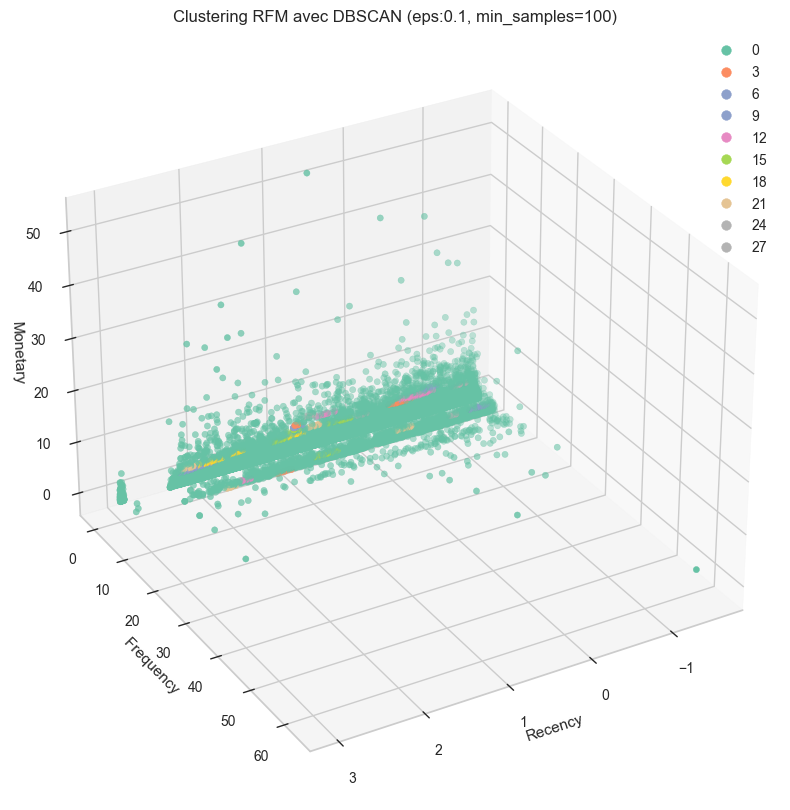

In [226]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', azim=60, elev=30)
scatter = ax.scatter(X_scaled[:, 0],
                     X_scaled[:, 1],
                     X_scaled[:, 2],
                     c=db_rfm_lab,
                     cmap=plt.cm.Set2)

ax.legend(*scatter.legend_elements())
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency ')
ax.set_zlabel('Monetary')
ax.set_title('Clustering RFM avec DBSCAN (eps:0.1, min_samples=100)')

plt.show()

**Avec min_sample = 10**

In [168]:
eps_range = [0.06, 0.07, 0.08, 0.09, 0.1]
min_samples = 10
dbscan_param_selection(X_scaled, eps_range, min_samples)

optimal_eps : 0.06255891875772175
Paramètres du modèle : epsilon : 0.06, min_samples : 10
Nombre de clusters avec le modèle DBSCAN :  74
Nombre de points considérés comme du bruit:  4606
Silhouette Score :  0.0859575725631674
--------------------------------------------------
Paramètres du modèle : epsilon : 0.07, min_samples : 10
Nombre de clusters avec le modèle DBSCAN :  53
Nombre de points considérés comme du bruit:  3742
Silhouette Score :  0.20292459611516003
--------------------------------------------------
Paramètres du modèle : epsilon : 0.08, min_samples : 10
Nombre de clusters avec le modèle DBSCAN :  44
Nombre de points considérés comme du bruit:  2964
Silhouette Score :  0.25952660702132185
--------------------------------------------------
Paramètres du modèle : epsilon : 0.09, min_samples : 10
Nombre de clusters avec le modèle DBSCAN :  33
Nombre de points considérés comme du bruit:  2468
Silhouette Score :  0.29038790581434604
------------------------------------------

In [169]:
db_rfm = DBSCAN(eps=0.1, min_samples=10)
db_rfm.fit(X_scaled)

DBSCAN(eps=0.1, min_samples=10)

In [170]:
db_rfm_lab = db_rfm.labels_

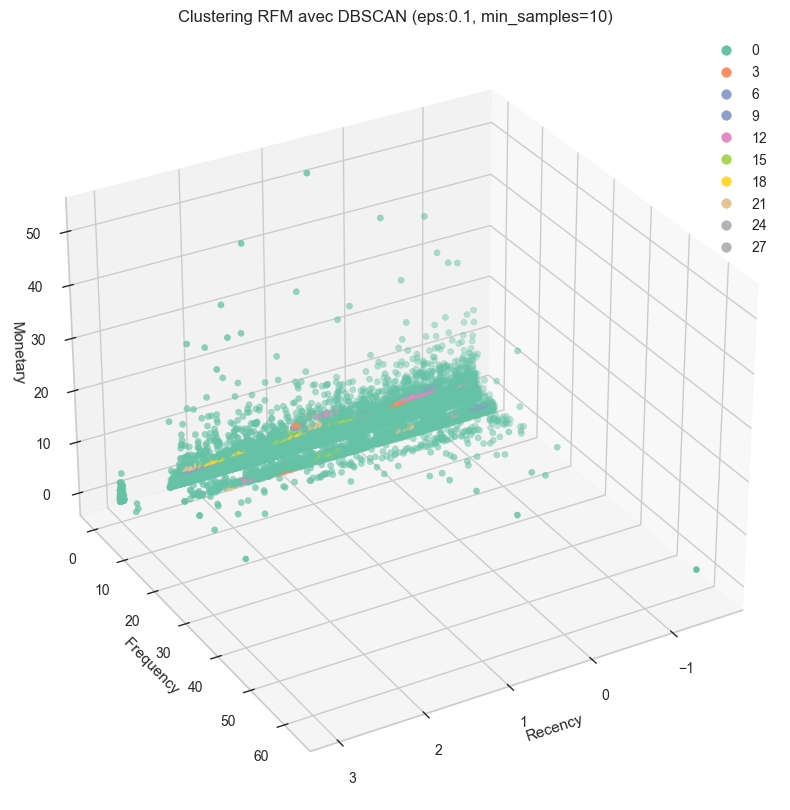

In [227]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', azim=60, elev=30)
scatter = ax.scatter(X_scaled[:, 0],
                     X_scaled[:, 1],
                     X_scaled[:, 2],
                     c=db_rfm_lab,
                     cmap=plt.cm.Set2)

ax.legend(*scatter.legend_elements())
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency ')
ax.set_zlabel('Monetary')
ax.set_title('Clustering RFM avec DBSCAN (eps:0.1, min_samples=10)')

plt.show()

L'analyse avec DBSCAN n'a pas donné de résultats concluants. En fixant `min_samples` à 100, nous avons obtenu un seul cluster avec 10248 points identifiés comme du bruit, ce qui rend la représentation peu interprétable. En diminuant `min_samples` à 10, nous avons observé 28 clusters avec 2110 points considérés comme du bruit, mais toujours avec un clustering difficile à interpréter.

Cette inefficacité peut s'expliquer par le fait que DBSCAN fonctionne sur la base de la densité des points, ce qui peut ne pas être adapté à notre jeu de données. La dispersion importante de nos clients autour de la moyenne pourrait être une des raisons de cette performance insatisfaisante.

En conséquence, nous avons décidé de ne pas poursuivre l'utilisation du modèle DBSCAN pour cette yanalse.


### 2.4) Agglomerative Clustering


L'agglomératif clustering est une méthode dclassificationnt non supervisée utilisée en apprentissage automatique pour partitionner un ensemble de données en groupes ou clustersL l'agglomératif clustering construit une hiérarchie de clusters sans supposer le nombre de clusters à l'avance.

Le principe de l'agglomératif clustering peut être résumé en quelques étapes- on**: Chaque point de données est initialement considéré comme un cluster dis
- rité**: La similarité entre chaque paire de clusters est calculée en utilisant une mesure de dissimilarité telle que la distance euclidienne, la distance de Manhattan, la similarité cosin
- usters**: Les deux clusters les plus similaires sont fusionnés pour former un nouveau cluster. Ce processus est répété jusqu'à ce qu'un critère d'arrêt soit atteint, par exemple lorsque tous les points de données sont regroupés dans un seul cluster ou lorsque le nombre de clusters atteint un seuil 
- rogramme**: Un dendrogramme est construit pour représenter la hiérarchie de regroupement. Les branches du dendrogramme représentent les fusions successives de clusters, tandis que la hauteur à laquelle les branches sont fusionnées représente la mesure de dissimilarité à laquelle les clusters ont ét
- e clusters**: En observant le dendrogramme, on peut choisir de couper à un niveau qui correspond à un nombre de clusters approprié en fonction des besoins de l'application ou en utilisant des critères tels que la coupure du dendrogramme à une hauteur qui maximise la variance inter-cluster ou minimise la variance intra-cluster.

L'agglomératif clustering est une méthode flexible et largement utilisée pour explorer la structure des données, identifier des groupes naturels et segmenter des ensembles de données complexes.


In [180]:
def agglomerative_clustering(X_scaled):
    clustering = AgglomerativeClustering(n_clusters=None)
    clustering.fit(X_scaled)

    labels = clustering.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} points")
    linked = linkage(X_scaled, method='ward')

    # Visualisation du dendrogramme
    dendrogram(linked)
    plt.title('Dendrogramme de l\'Agglomerative Clustering')
    plt.xlabel('Indice de l\'échantillon')
    plt.ylabel('Distance')
    plt.show()

    #Visualisation des clusters
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Recency (normalized)')
    ax.set_ylabel('Frequency (normalized)')
    ax.set_zlabel('Monetary (normalized)')
    plt.title('Agglomerative Clustering')
    plt.show()

In [176]:
def agglomerative_clustering(X_scaled):
    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)  # Ne spécifie pas le nombre de clusters
    clustering.fit(X_scaled)

    labels = clustering.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} points")
    linked = linkage(X_scaled, method='ward')

    # Visualisation du dendrogramme
    dendrogram(linked)
    plt.title('Dendrogramme de l\'Agglomerative Clustering')
    plt.xlabel('Indice de l\'échantillon')
    plt.ylabel('Distance')
    plt.show()

    # Visualisation des clusters
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Recency (normalized)')
    ax.set_ylabel('Frequency (normalized)')
    ax.set_zlabel('Monetary (normalized)')
    plt.title('Agglomerative Clustering')
    plt.show()


In [185]:
sampled_data = resample(X_scaled, n_samples=20000, random_state=42)

Cluster 0: 19429 points
Cluster 1: 571 points


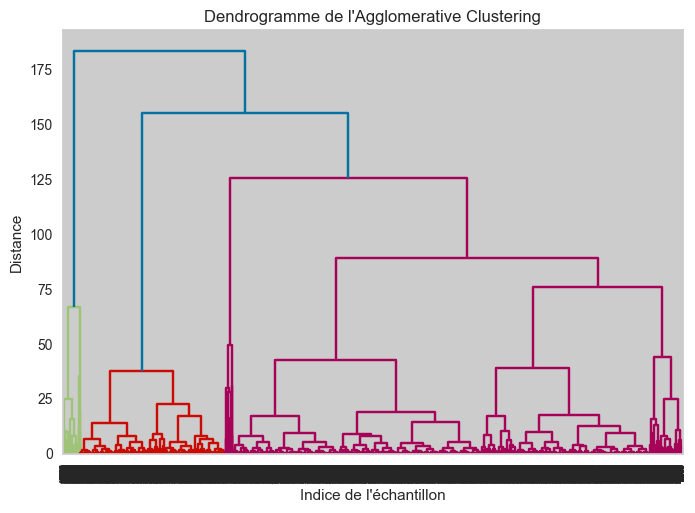

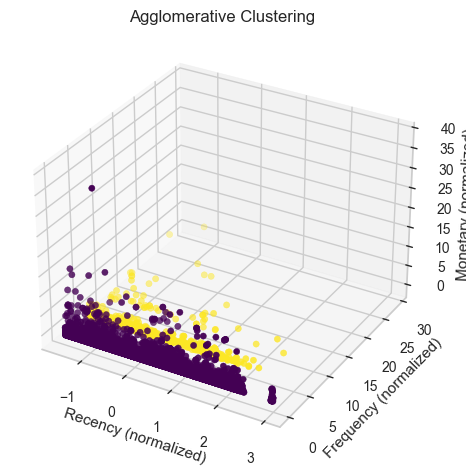

In [186]:
agglomerative_clustering(sampled_data)

L'Agglomerative Clustering a été testé pour la segmentation des données, cependant, les clusters obtenus ne fournissent pas une séparation significative des données. La structure des données semble être mal capturée par cette méthode. On se retrouve avec un cluster contenant la quasi totalité des individus ce qui ne représente pas une segmentation. Cela peut être dû à plusieurs facteurs, tels que la sensibilité de l'algorithme à la forme des clusters ou à la densité des données.

Contrairement à l'Agglomerative Clustering, la méthode K-Means a mieux réussi à capturer la structure des données et à produire des clusters qui permettent une séparation plus clairet  einterprétabve. En conséquence, la décision de privilégier la méthode K-Means est basée sur sa capacité à mieux représenter la structure sous-jacente des données plutôt que sur des considérations de taille de cluster uniquemt.ns.


## III- Ajout du review_score

In [187]:
review = df[['customer_unique_id', 'mean_review_score']]
review = pd.merge(review, rfm, on='customer_unique_id')
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  91481 non-null  object 
 1   mean_review_score   91481 non-null  float64
 2   recency             91481 non-null  int64  
 3   frequency           91481 non-null  int64  
 4   monetary            91481 non-null  float64
 5   R                   91481 non-null  int64  
 6   F                   91481 non-null  int64  
 7   M                   91481 non-null  int64  
 8   RFM_score           91481 non-null  int64  
 9   Segment             91481 non-null  object 
 10  cluster             91481 non-null  int32  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 7.3+ MB


In [188]:
# Normalisation des données
X_review = review[['recency', 'frequency', 'monetary', 'mean_review_score']]
scaler_review = StandardScaler()
X_review_scaled = scaler_review.fit_transform(X_review)

### 3.1) KElbowVisualizer

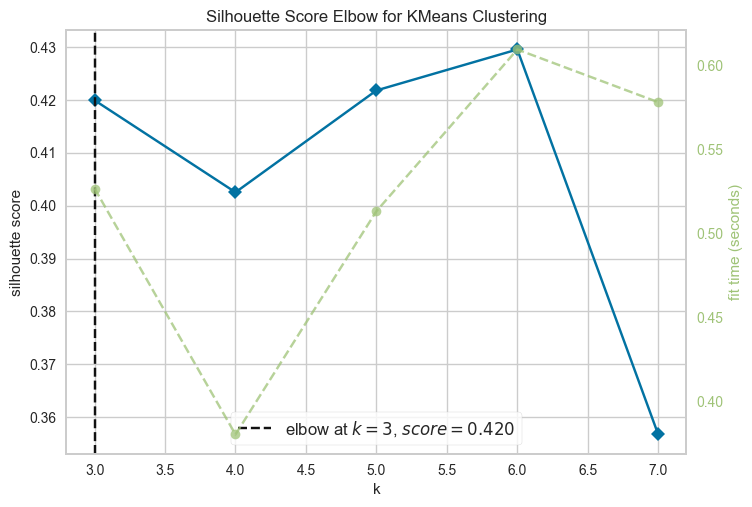

In [189]:
review_kmean = elbow_visualizer(3, 8, X_review_scaled, 'silhouette')

In [190]:
result_review_kmeans = pd.DataFrame(data={'k': np.arange(3, 8),
                                      'sil_scores': review_kmean.k_scores_,
                                      'temps': review_kmean.k_timers_})

result_review_kmeans

k  sil_scores     temps
0  3    0.419922  0.526679
1  4    0.402530  0.380124
2  5    0.421784  0.513164
3  6    0.429527  0.609536
4  7    0.356754  0.578117

Cette méthode nous indique que la segmentation en 3 clusters (k=3) semble être la plus pertinente.

### 3.2) SilhouetteVisualizer

In [191]:
k_selected_review = review_kmean.elbow_value_
k_selected_review

3

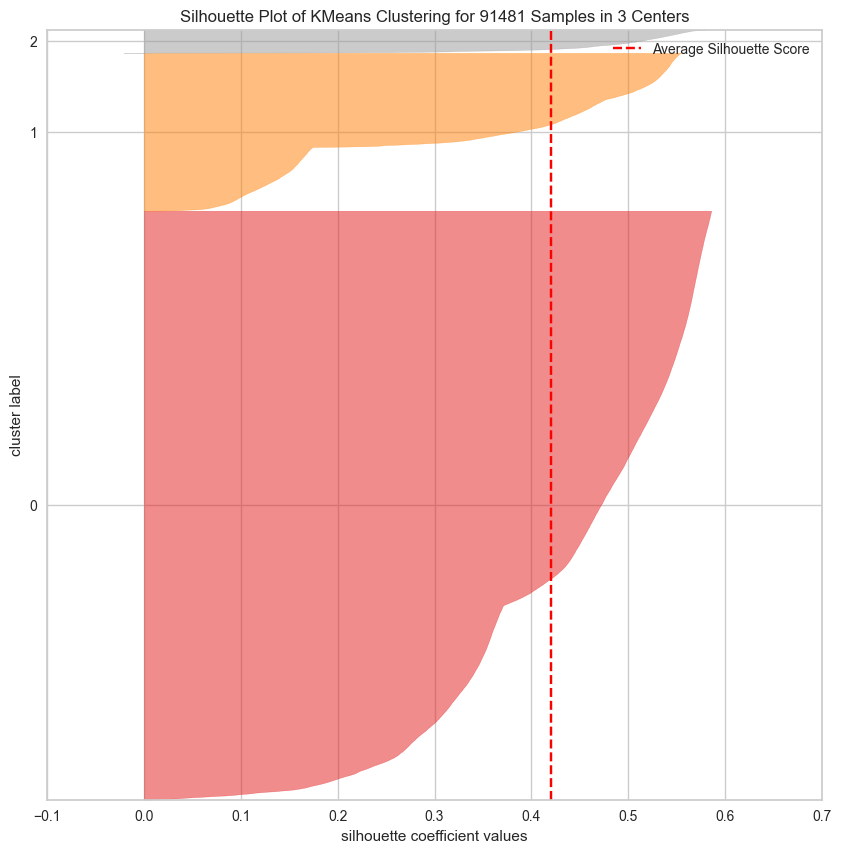

In [192]:
silhouette_visualizer(k_selected_review, X_review_scaled)

### 3.3) Distance inter-cluster

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


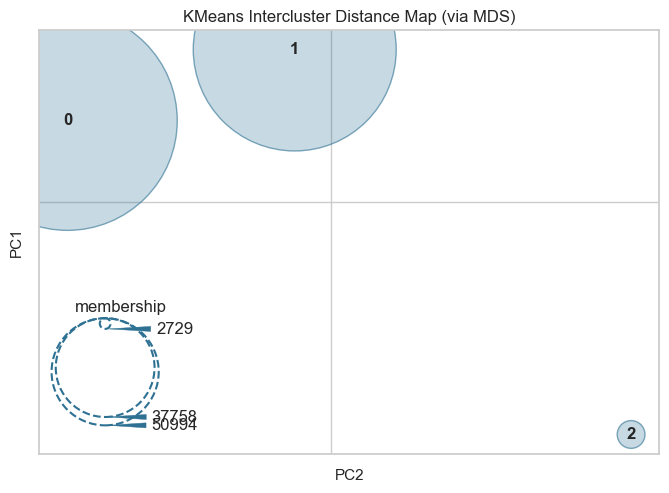

In [193]:
distance_visualizer(k_selected_review, X_review_scaled)

- On constate que pour k=3, les cluster semblent bien séparés. 

### 3.4) Analyse des clusters

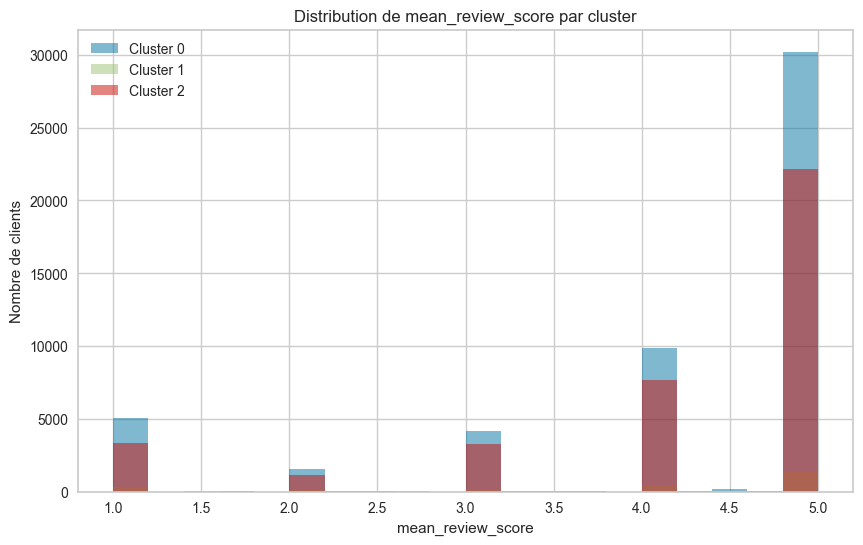

In [194]:
plt.figure(figsize=(10, 6))
for cluster in range(k_selected_review):
    plt.hist(review[review['cluster'] == cluster]['mean_review_score'], bins=20, alpha=0.5, label=f'Cluster {cluster}')
plt.title(f'Distribution de mean_review_score par cluster')
plt.xlabel('mean_review_score')
plt.ylabel('Nombre de clients')
plt.legend()
plt.show()

Nombre de clients par cluster :
cluster
0    51208
1     2503
2    37770
Name: count, dtype: int64


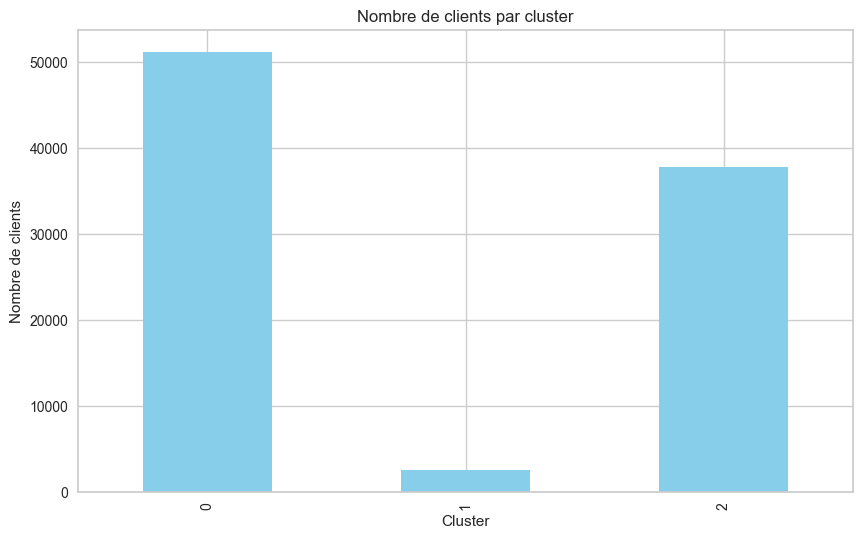

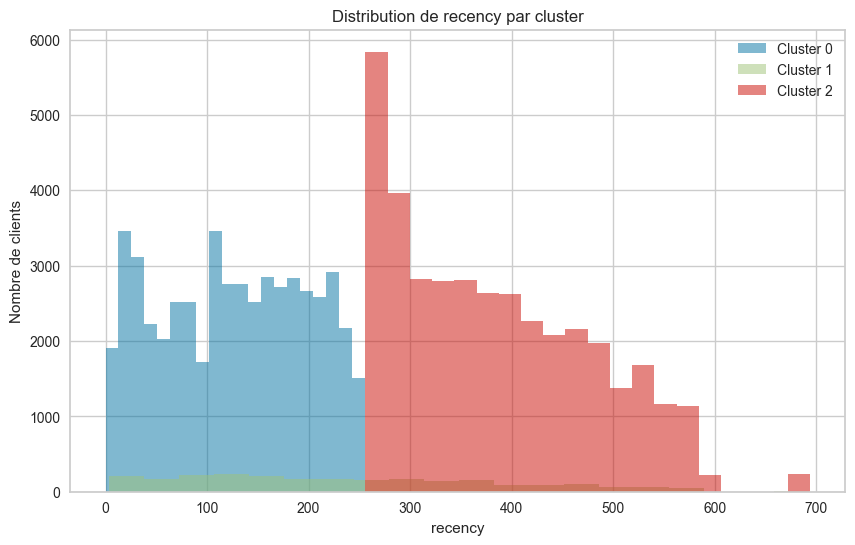

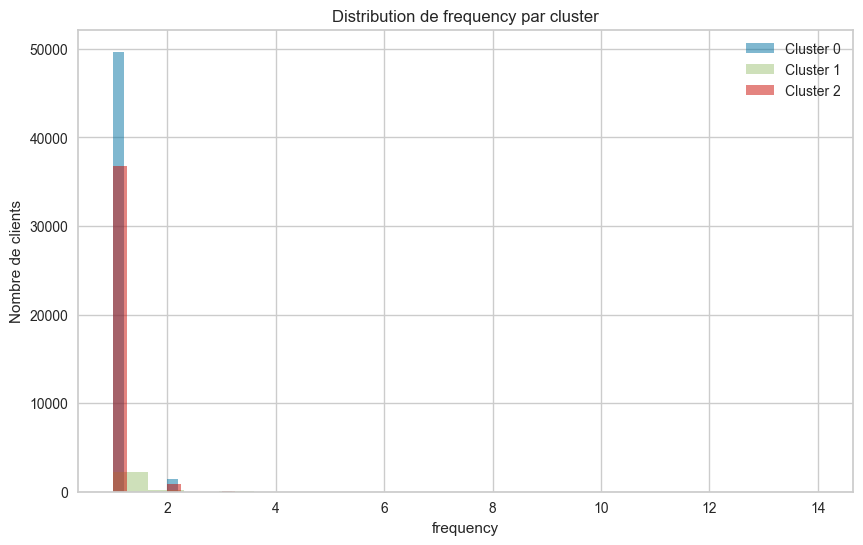

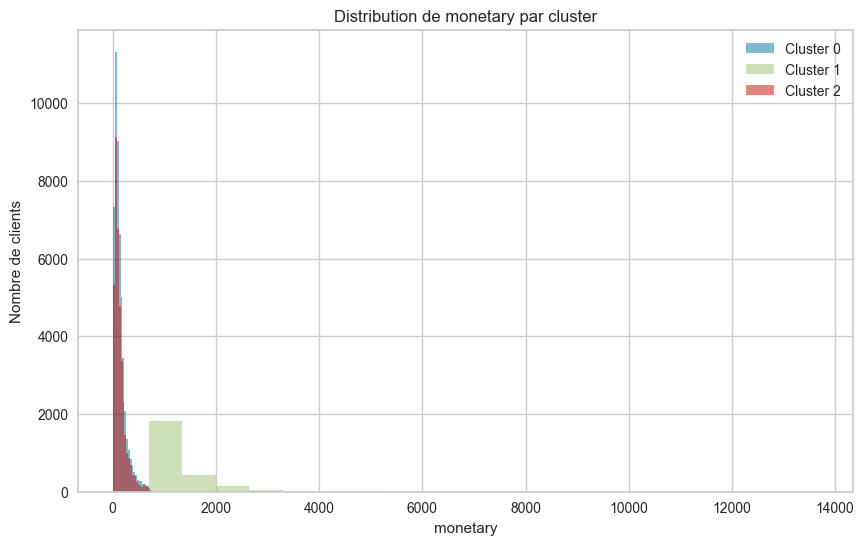

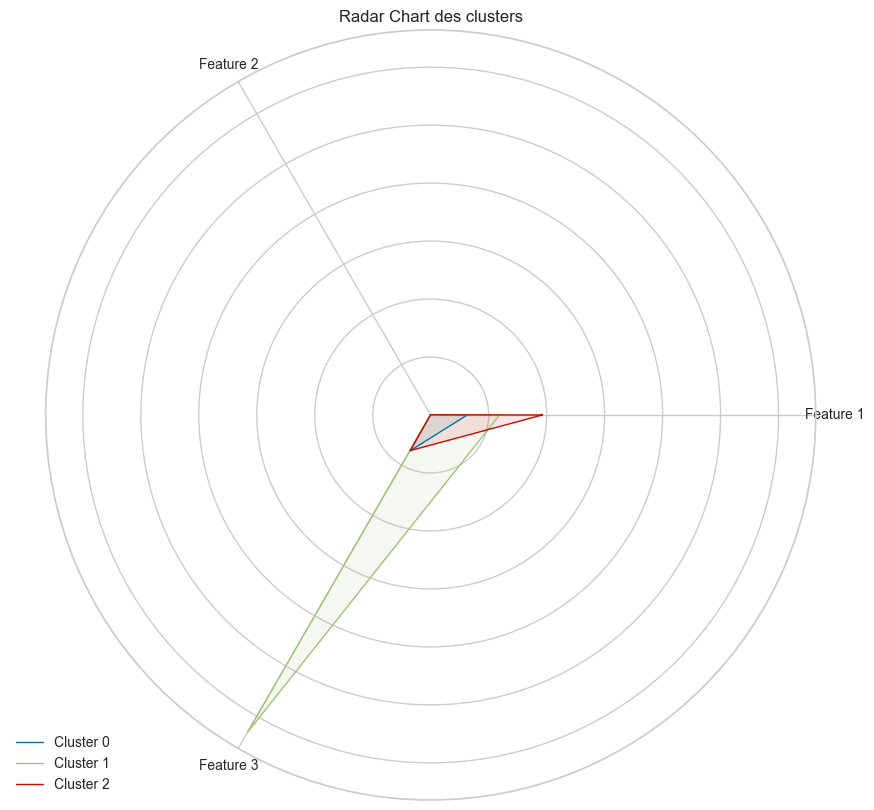

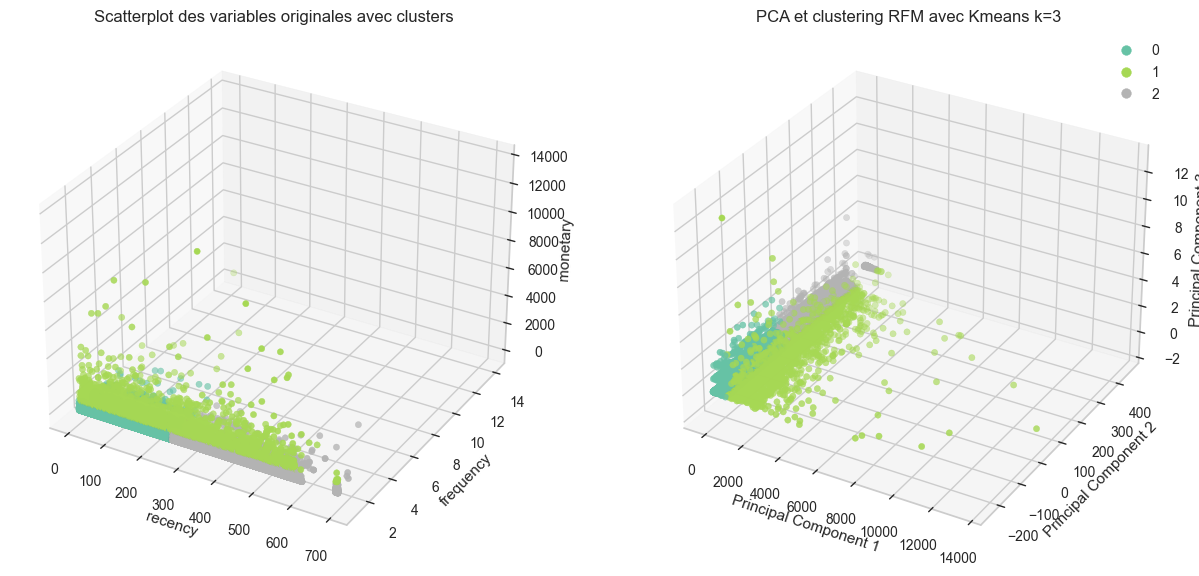

In [195]:
kmeans_analysis(review, k_selected_review)

Les différentes représentations nous permettent de constater que le clustering (k=3) effectué semble offrir la même interprétation que sans la variable de satisfaction  :

- **Cluster 0 :** Clients ayant commandé récemment, la plupart du temps pour la première fois et pour des montants faibles. Ce cluster ne se différencie pas par le review_score, avec des clients aussi satisfaits que mécontents.

- **Cluster 1 :** Clients ayant commandé à la fois récemment et il y a longtemps, pour la plupart une seule fois, mais pour des montants élevés et avec une note de satisfaction très élevée (majoritairement 5).

- **Cluster 2 :** Même clientèle que le cluster 0, à la différence qu'ils ont commandé il y a longtemps et non récemment.
ment."

## IV- Ajout des catégories de produits

On factorise les variables que nous allons utiliser 

In [228]:
#product_category_name_english
df.loc[df['product_category_name'].isin(['food_drink', 'drinks', 'food']), 'product_category_name_english'] = 'food_and_drink'
df.loc[df['product_category_name'].isin(['fashion_bags_accessories', 'fashio_female_clothing', 'fashion_male_clothing', 'fashion_shoes', 'fashion_underwear_beach', 'fashion_sport', 'fashion_childrens_clothes', 'fashion_furniture', 'luggage_accessories', 'watches_gifts']), 'product_category_name_english'] = 'fashion'
df.loc[df['product_category_name'].isin(['home_confort', 'home_comfort_2', 'home_appliances_2', 'la_cuisine']), 'product_category_name_english'] = 'home'
df.loc[df['product_category_name'].isin(['toys', 'musical_instruments', 'arts_and_craftmanship', 'party_supplies', 'sports_leisure']), 'product_category_name_english'] = 'leisure'
df.loc[df['product_category_name'].isin(['health_beauty', 'perfumery', 'diapers_and_hygiene']), 'product_category_name_english'] = 'beauty'
df.loc[df['product_category_name'].isin(['construction_tools_construction', 'construction_tools_safety', 'construction_tools_lights', 'costruction_tools_tools', 'home_construction', 'costruction_tools_garden']), 'product_category_name_english'] = 'construction'
df.loc[df['product_category_name'].isin(['computers_accessories', 'consoles_games', 'electronics', 'fixed_telephony', 'telephony', 'computers', 'tablets_printing_image']), 'product_category_name_english'] = 'multimedia'
df.loc[df['product_category_name'].isin(['audio', 'dvds_blu_ray', 'music', 'cds_dvds_musicals']), 'product_category_name_english'] = 'audiovisuel'
df.loc[df['product_category_name'].isin(['books_general_interest', 'books_technical', 'books_imported', 'cine_photo']), 'product_category_name_english'] = 'books'
df.loc[df['product_category_name'].isin(['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'furniture_bedroom', 'furniture_mattress_and_upholstery', 'housewares', 'stationery', 'christmas_supplies']), 'product_category_name_english'] = 'home_furniture'
df.loc[df['product_category_name'].isin(['air_conditioning', 'home_appliances', 'small_appliances_home_oven_and_coffee', 'small_appliances']), 'product_category_name_english'] = 'appliance'

df['product_category_name_english'].unique()

array(['home_furniture', 'beauty', 'multimedia', nan, 'leisure',
       'fashion', 'appliance', 'home', 'construction', 'food_and_drink',
       'books', 'audiovisuel'], dtype=object)

In [229]:
review_product = df[['customer_unique_id', 'product_category_name_english']]
review_product = pd.merge(rfm, review_product, on='customer_unique_id')
review_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             91481 non-null  object 
 1   recency                        91481 non-null  int64  
 2   frequency                      91481 non-null  int64  
 3   monetary                       91481 non-null  float64
 4   R                              91481 non-null  int64  
 5   F                              91481 non-null  int64  
 6   M                              91481 non-null  int64  
 7   RFM_score                      91481 non-null  int64  
 8   Segment                        91481 non-null  object 
 9   cluster                        91481 non-null  int32  
 10  product_category_name_english  75696 non-null  object 
dtypes: float64(1), int32(1), int64(6), object(3)
memory usage: 7.3+ MB


_**One-Hot Encoding**_

In [230]:
review_product_categorie = pd.get_dummies(df['product_category_name_english'], prefix='product_category')
review_product = pd.concat([review_product, review_product_categorie], axis=1)
review_product = review_product.drop(['product_category_name_english'], axis=1)

_**Normalisation des données**_

In [231]:
columns_to_drop = ['customer_unique_id', 'R', 'F', 'M', 'RFM_score', 'Segment']
X_review_product = review_product.drop(columns=columns_to_drop)
scaler_review_product = StandardScaler()
X_review_product_scaled = scaler_review_product.fit_transform(X_review_product)

_**KElbowVisualizer**_

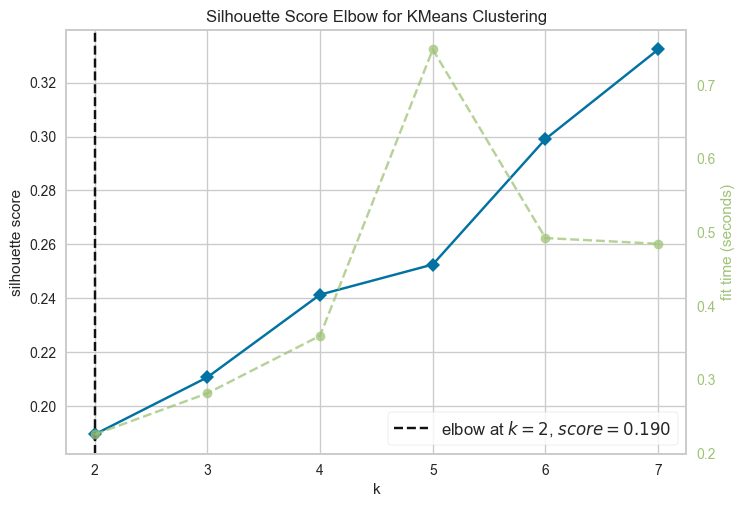

In [232]:
review_product_kmean = elbow_visualizer(2, 8, X_review_product_scaled, 'silhouette')

In [233]:
result_review_product_kmeans = pd.DataFrame(data={'k': np.arange(2, 8),
                                      'sil_scores': review_product_kmean.k_scores_,
                                      'temps': review_product_kmean.k_timers_})

result_review_product_kmeans

k  sil_scores     temps
0  2    0.189515  0.225383
1  3    0.210708  0.281242
2  4    0.241368  0.359378
3  5    0.252549  0.748149
4  6    0.299094  0.492069
5  7    0.332294  0.484343

Cette méthode nous indique que la segmentation en 2 clusters (k=2) semble être la plus pertinente.

_**SilhouetteVisualizer**_

In [234]:
k_selected_review_product = review_product_kmean.elbow_value_
k_selected_review_product

2

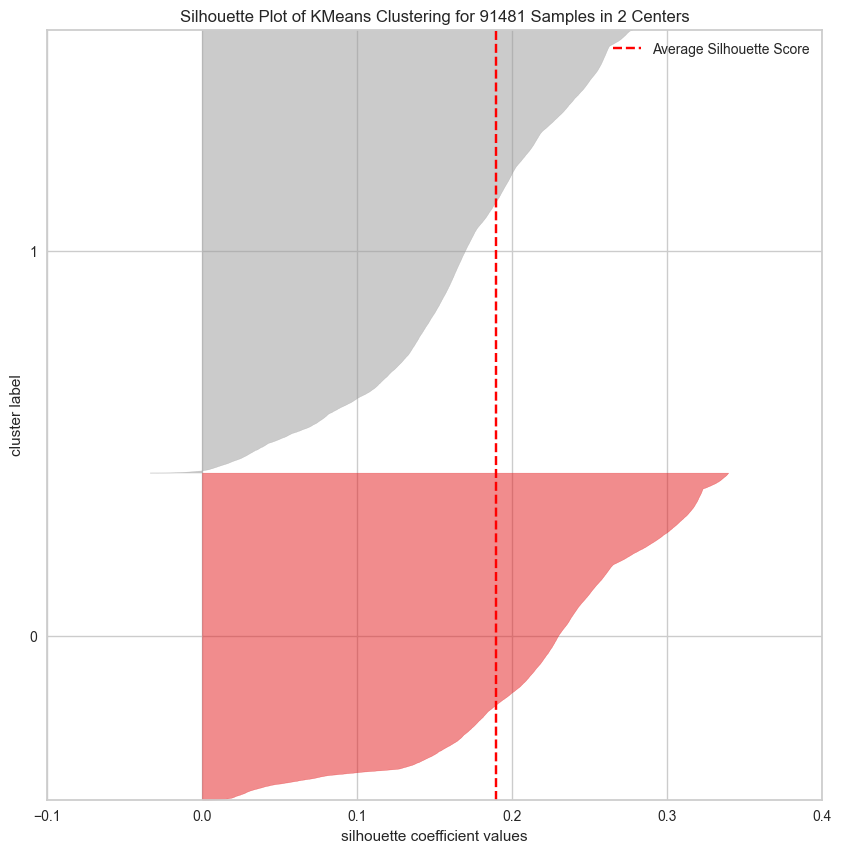

In [235]:
silhouette_visualizer(k_selected_review_product, X_review_product_scaled)

On constate que les clusters sont relativement proportionnels. On note aussi des silhouettes score positifs mais aussi négatifs, ce indiquent que les échantillons ont peut-être été affectés au mauvais cluster. Le silhouette score moyen se situe près de 0.17.

_**Distance inter-cluster**_

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


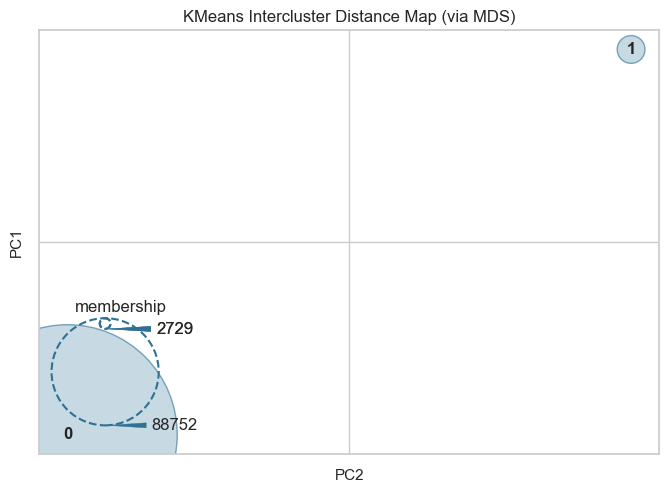

In [236]:
distance_visualizer(k_selected_review_product, X_review_product_scaled)

_**Analyse des clusters**_

Nombre de clients par cluster :
cluster
0    88782
1     2699
Name: count, dtype: int64


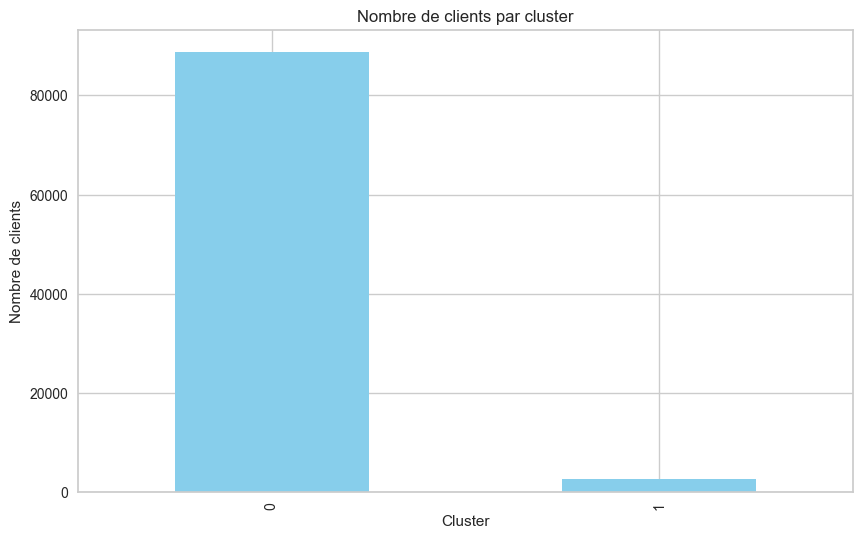

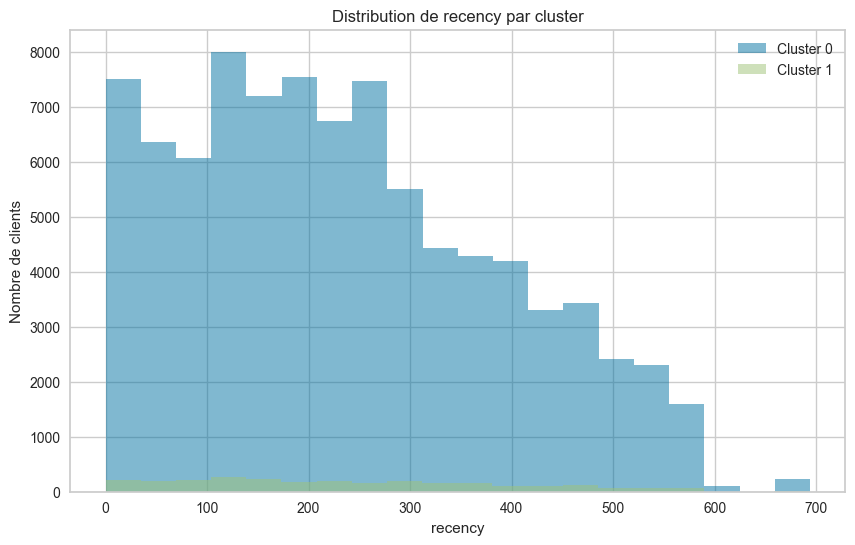

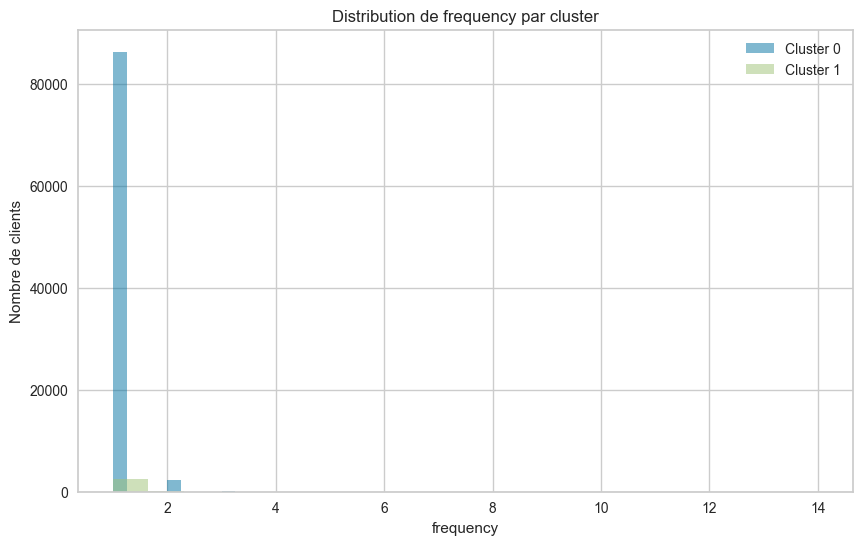

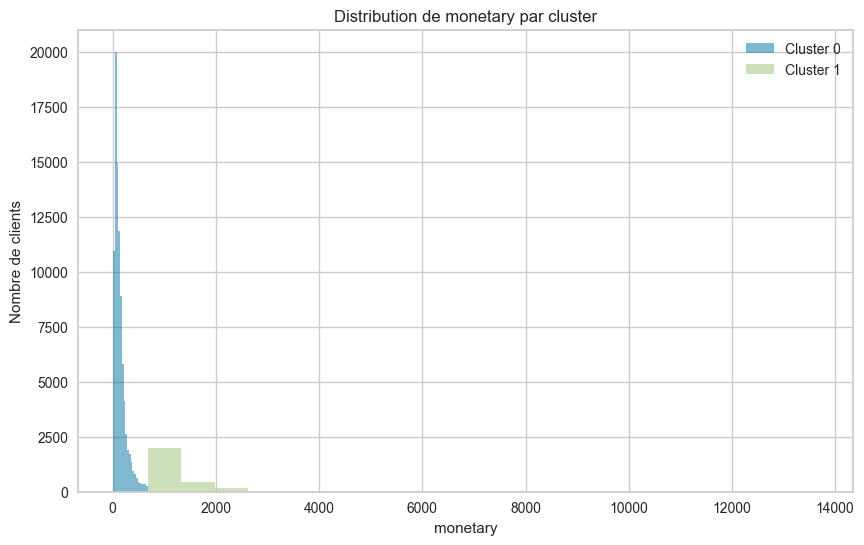

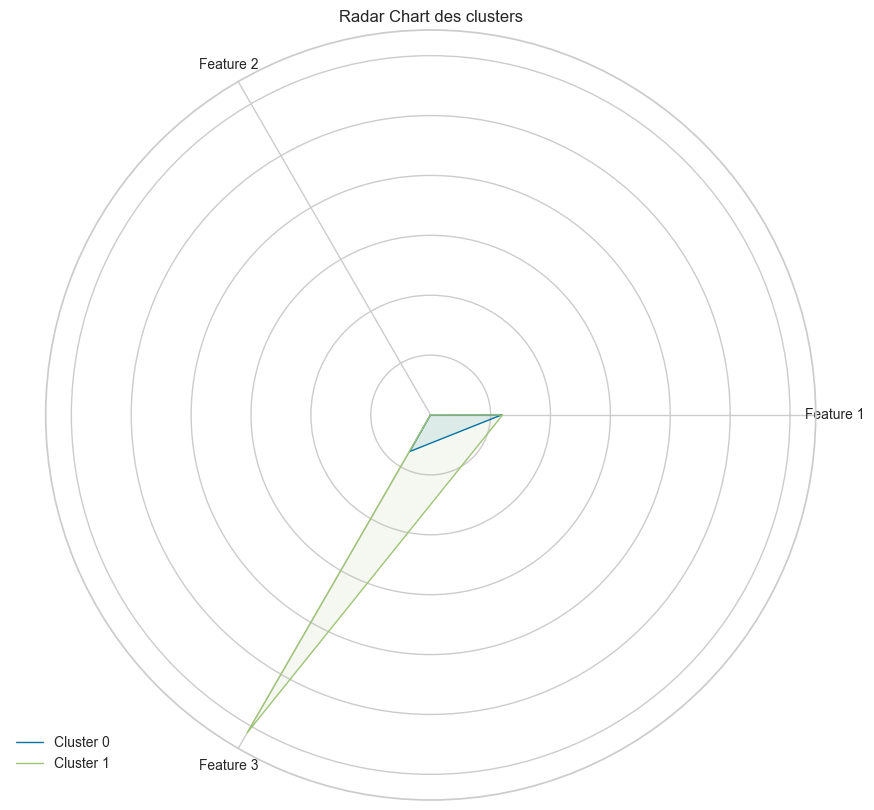

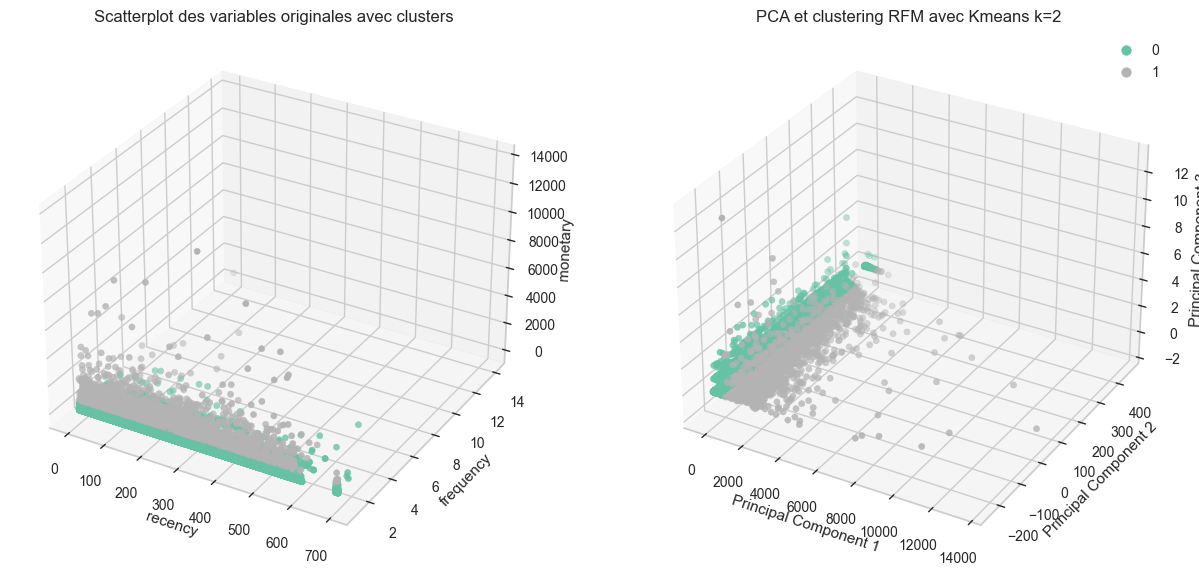

In [237]:
kmeans_analysis(review_product, k_selected_review_product)

Il semble que l'ajout de la variable _**catégorie des produits**_ détériore la qualité du clustering rendant l'interprétation moins qualitative. On décide de ne pas conserver cette variable.

## V- Ajout des variables de paiements

On ajoute des variables sur le paiement telles que le type de paiement ou le nombre de paiement.

In [238]:
def factorise_et_supprime(df, column_name, nb_categories=10):
    print(df[column_name].describe())
    df[column_name + '_categorie'] = pd.cut(df[column_name], bins=nb_categories, labels=False)
    print(df[column_name + '_categorie'].value_counts())
    df = df.drop([column_name], axis=1)
    return df

In [239]:
with_paiment = df[['customer_unique_id', 'payment_type', 'mean_payment_installments']]
with_paiment = pd.merge(rfm, with_paiment, on='customer_unique_id')
with_paiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         91481 non-null  object 
 1   recency                    91481 non-null  int64  
 2   frequency                  91481 non-null  int64  
 3   monetary                   91481 non-null  float64
 4   R                          91481 non-null  int64  
 5   F                          91481 non-null  int64  
 6   M                          91481 non-null  int64  
 7   RFM_score                  91481 non-null  int64  
 8   Segment                    91481 non-null  object 
 9   cluster                    91481 non-null  int32  
 10  payment_type               91481 non-null  object 
 11  mean_payment_installments  91481 non-null  float64
dtypes: float64(2), int32(1), int64(6), object(3)
memory usage: 8.0+ MB


In [240]:
with_paiment_categorie = pd.get_dummies(with_paiment['payment_type'], prefix='payment_type')
with_paiment = pd.concat([with_paiment, with_paiment_categorie], axis=1)
with_paiment = with_paiment.drop(['payment_type'], axis=1)

In [241]:
columns_to_drop = ['customer_unique_id', 'R', 'F', 'M', 'RFM_score', 'Segment', 'cluster']
X_with_paiment = with_paiment.drop(columns=columns_to_drop)
scaler_with_paiment = StandardScaler()
X_with_paiment_scaled = scaler_with_paiment.fit_transform(X_with_paiment)

In [242]:
imputer = SimpleImputer(strategy='mean')
X_with_paiment_scaled = imputer.fit_transform(X_with_paiment_scaled)

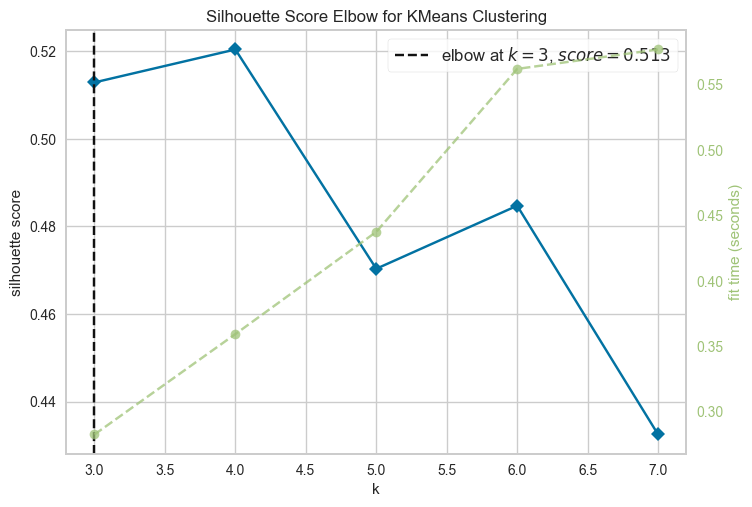

In [243]:
with_paiment_kmean = elbow_visualizer(3, 8, X_with_paiment_scaled, 'silhouette')

In [244]:
result_with_paiment_kmeans = pd.DataFrame(data={'k': np.arange(3, 8),
                                      'sil_scores': with_paiment_kmean.k_scores_,
                                      'temps': with_paiment_kmean.k_timers_})

result_with_paiment_kmeans

k  sil_scores     temps
0  3    0.512884  0.282620
1  4    0.520410  0.359354
2  5    0.470323  0.437513
3  6    0.484721  0.562052
4  7    0.432470  0.576917

In [245]:
k_selected_with_paiment = with_paiment_kmean.elbow_value_
k_selected_with_paiment

3

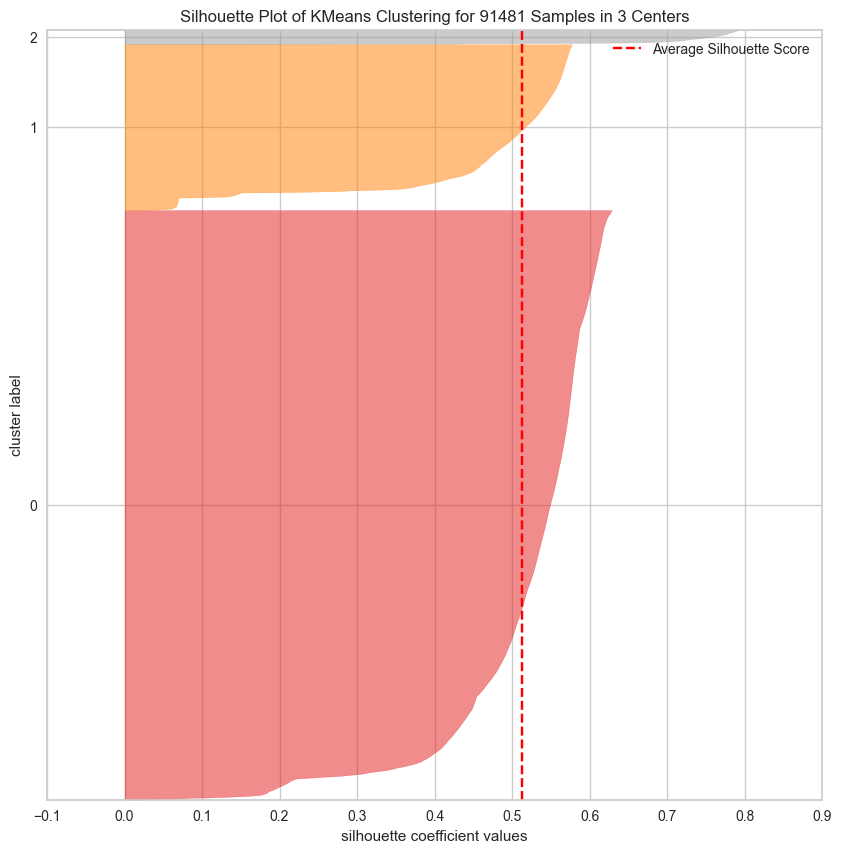

In [246]:
silhouette_visualizer(k_selected_with_paiment, X_with_paiment_scaled)

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


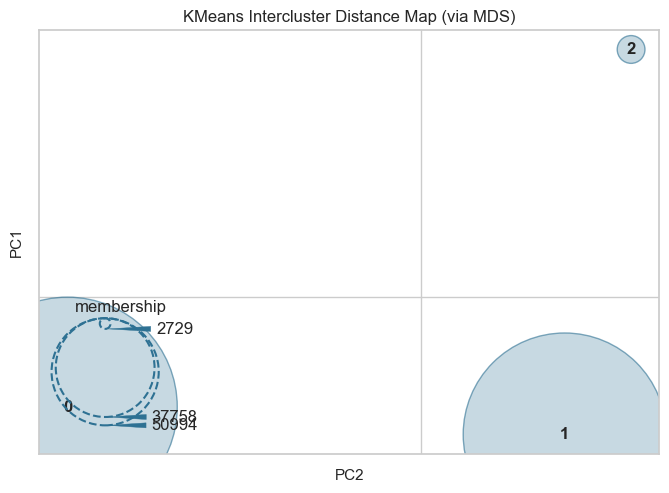

In [247]:
distance_visualizer(k_selected_with_paiment, with_paiment)

Nombre de clients par cluster :
cluster
0    51208
1     2503
2    37770
Name: count, dtype: int64


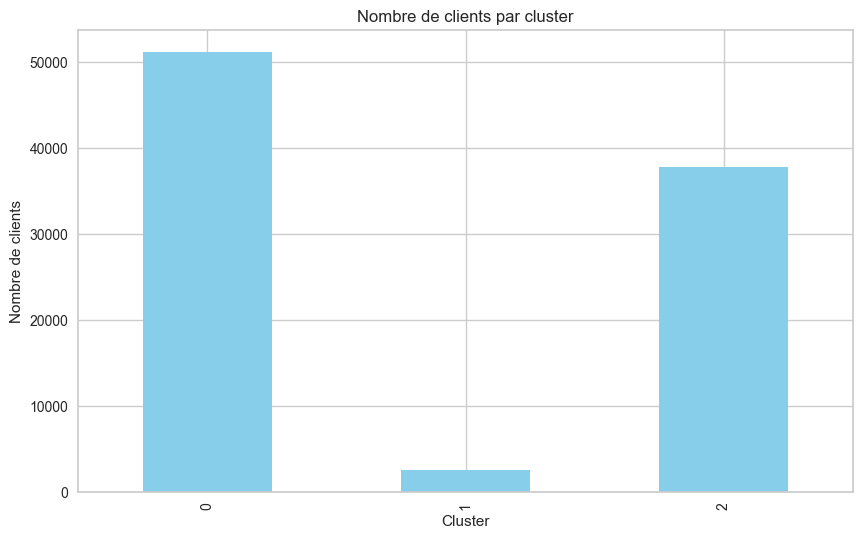

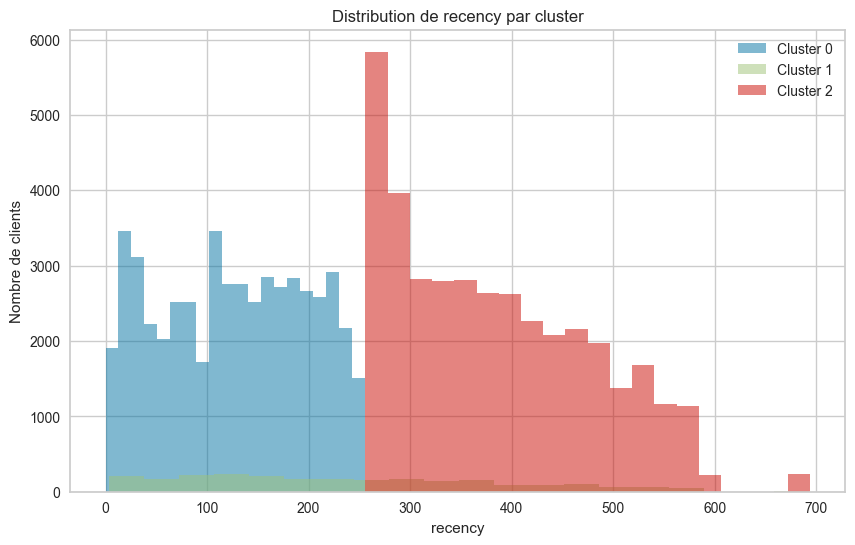

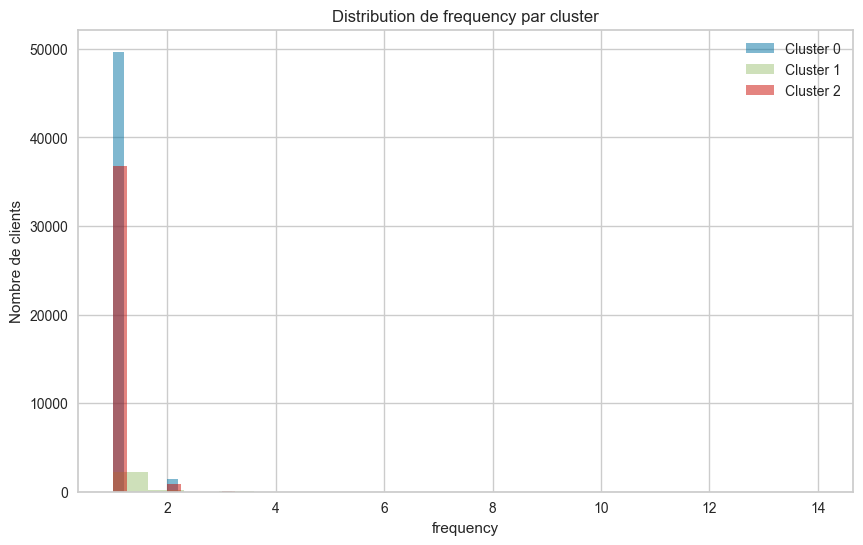

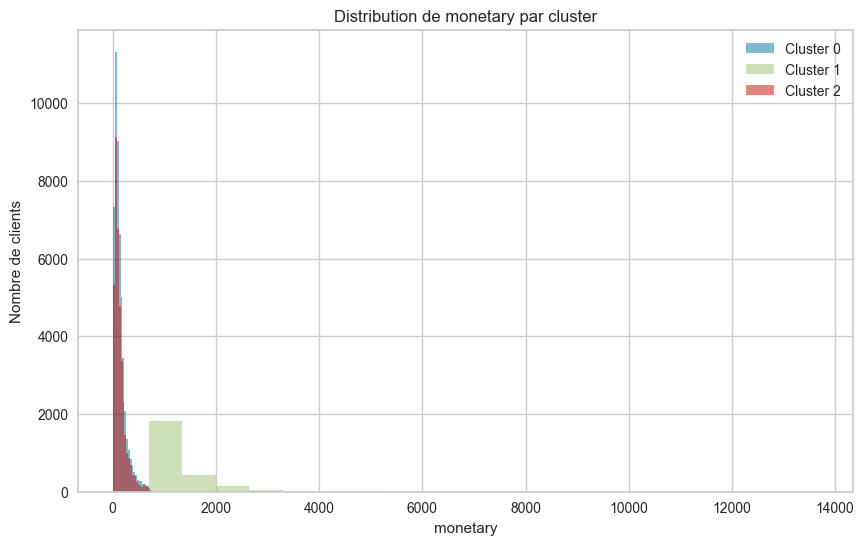

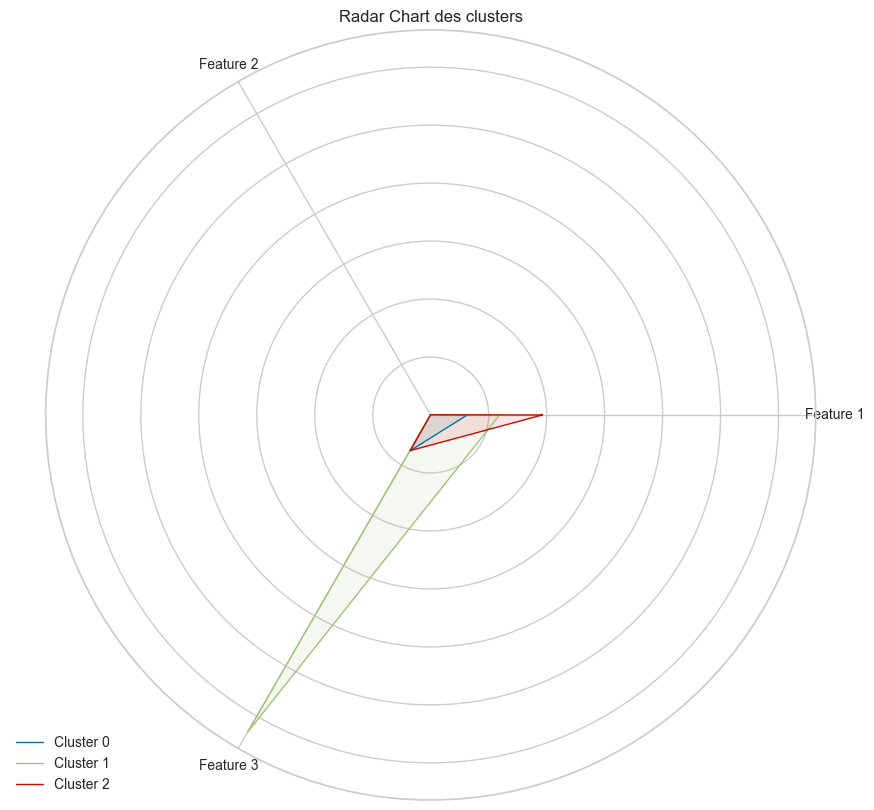

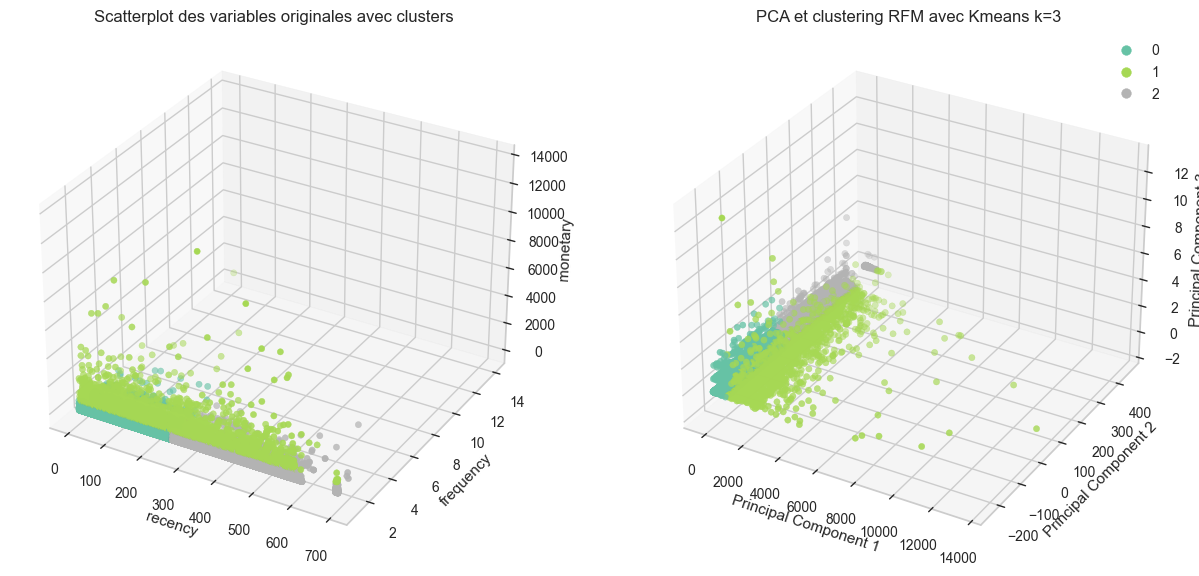

In [248]:
kmeans_analysis(with_paiment, k_selected_with_paiment)

D'après nos observations, l'ajout des variables de paiement semble offrir la même interprétation que sans la variable de satisfaction. Cela s'explique par le fait que plus de 96 % des commandes ont été effectuées avec un seul moyen de paiement.

### VI- Ajout d'une variable pays

In [249]:
with_sp_only = rfm[['recency', 'frequency', 'monetary']].copy()
with_sp_only['sp_customer'] = (df['customer_state'] == 'SP').astype(int)
with_sp_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   recency      91481 non-null  int64  
 1   frequency    91481 non-null  int64  
 2   monetary     91481 non-null  float64
 3   sp_customer  91481 non-null  int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 2.4 MB


In [250]:
scaler_with_sp_only = StandardScaler()
with_sp_only_scaled = scaler_with_sp_only.fit_transform(with_sp_only)

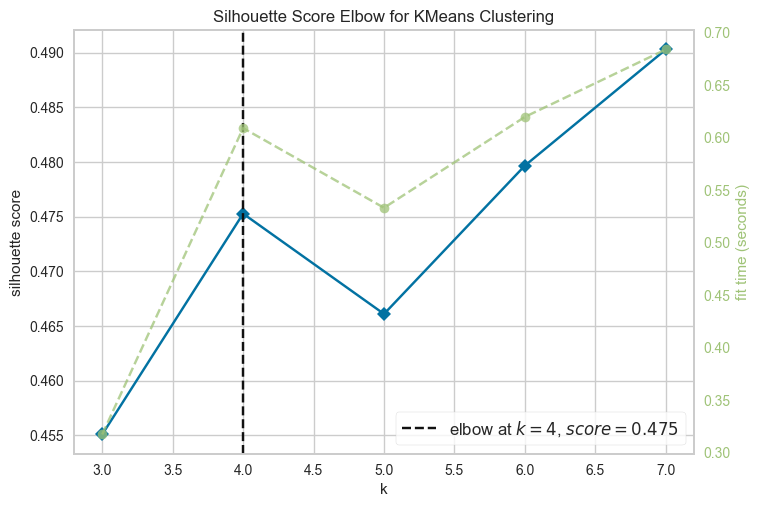

In [251]:
with_sp_only_kmean = elbow_visualizer(3, 8, with_sp_only_scaled, 'silhouette')

In [252]:
result_with_sp_only_kmeans = pd.DataFrame(data={'k': np.arange(3, 8),
                                      'sil_scores': with_sp_only_kmean.k_scores_,
                                      'temps': with_sp_only_kmean.k_timers_})

result_with_sp_only_kmeans

k  sil_scores     temps
0  3    0.455089  0.317425
1  4    0.475284  0.608963
2  5    0.466111  0.533133
3  6    0.479684  0.619635
4  7    0.490302  0.683789

In [253]:
k_selected_with_sp_only = with_sp_only_kmean.elbow_value_
k_selected_with_sp_only

4

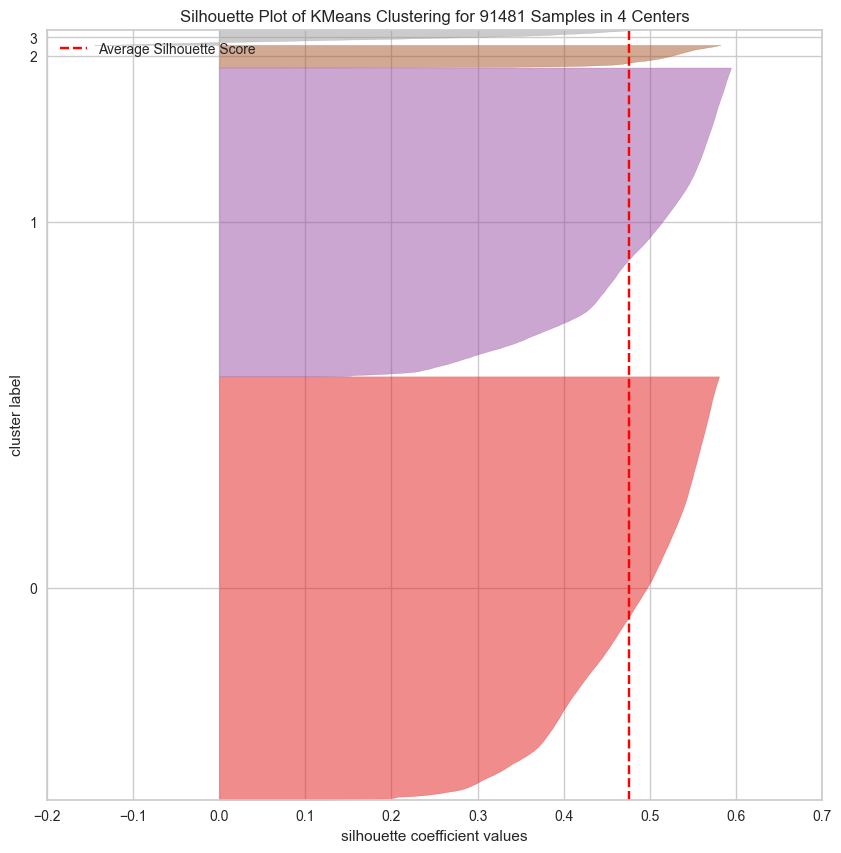

In [254]:
silhouette_visualizer(k_selected_with_sp_only, with_sp_only_scaled)

D:\Programme\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


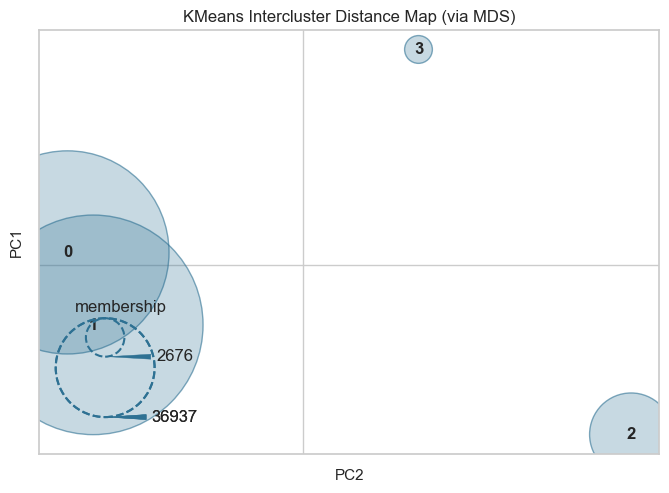

In [255]:
distance_visualizer(k_selected_with_sp_only, with_sp_only_scaled)

Nombre de clients par cluster :
cluster
0    49264
1      464
2    36476
3     5277
Name: count, dtype: int64


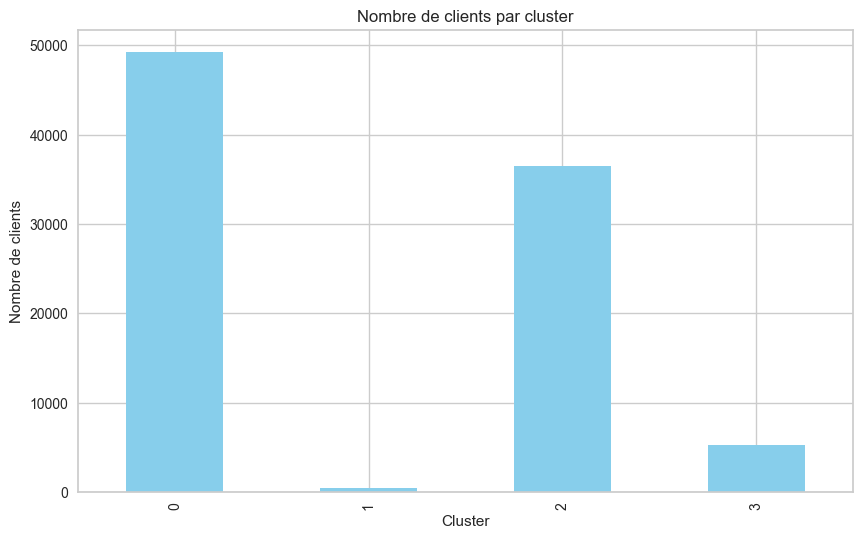

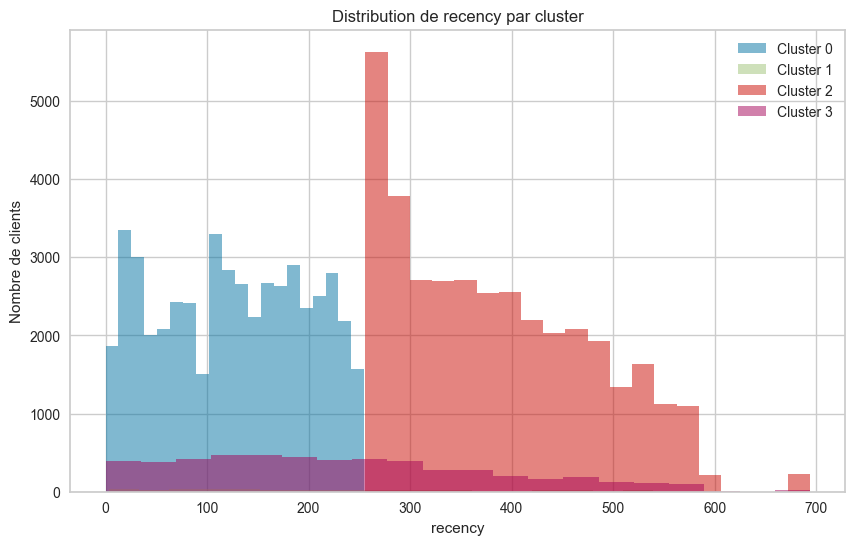

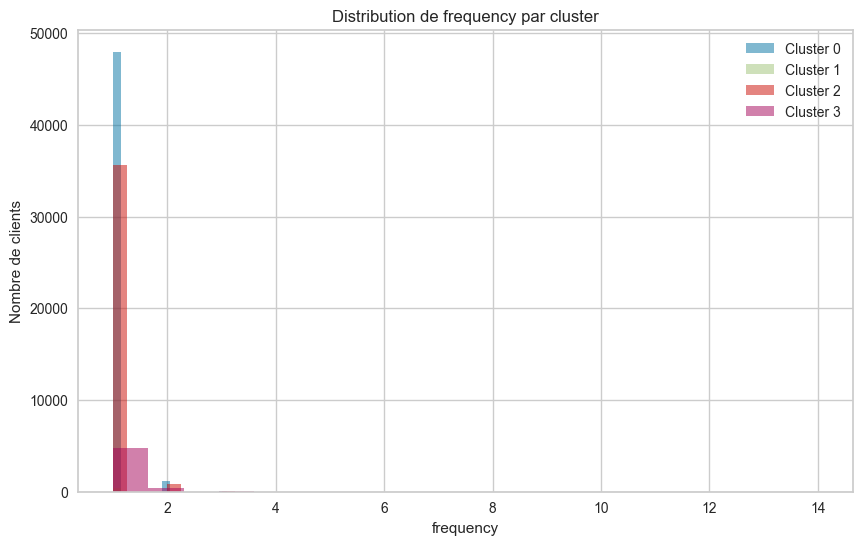

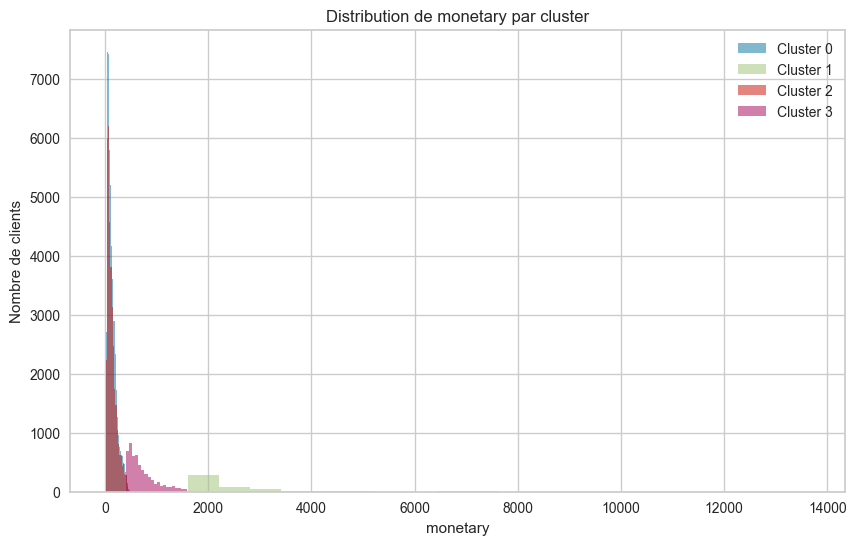

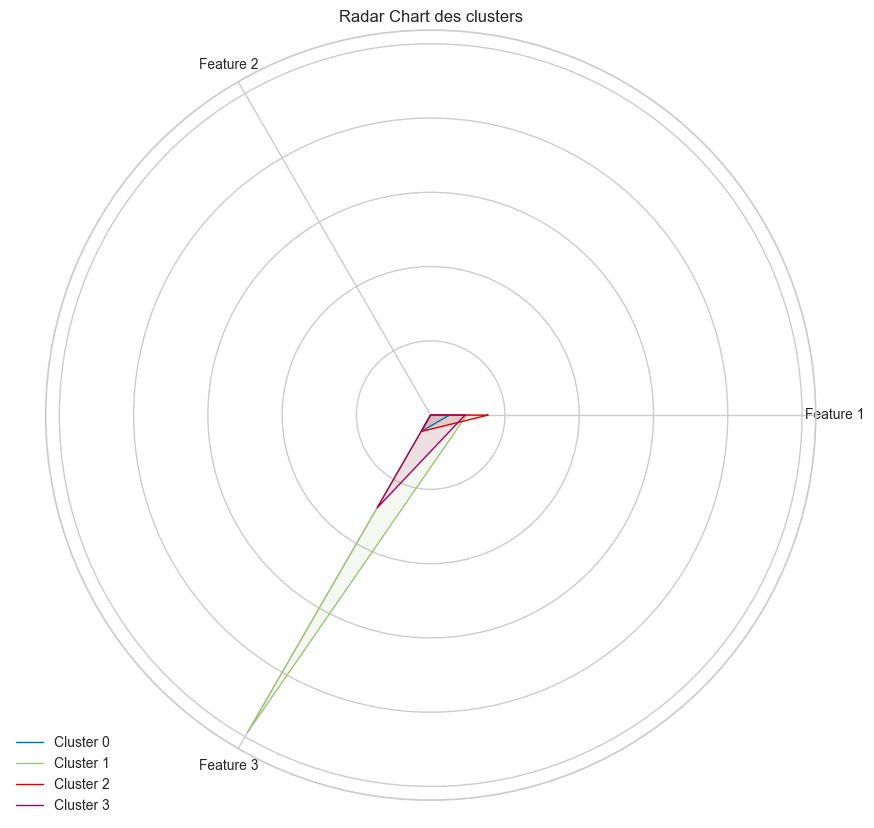

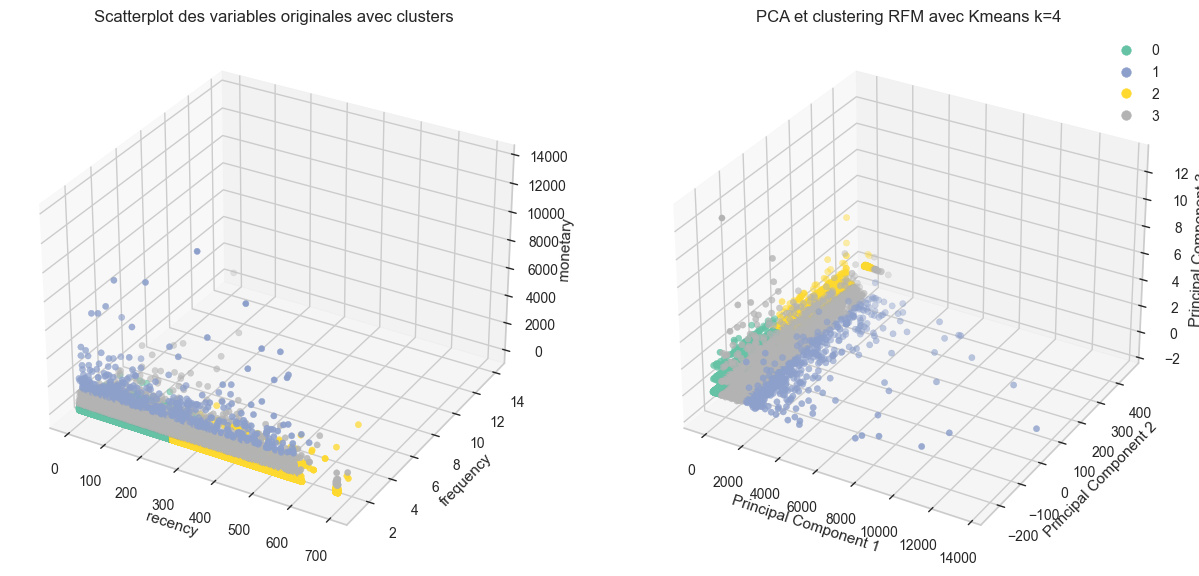

In [256]:
kmeans_analysis(with_sp_only, k_selected_with_sp_only)

## Conclusion de l'Analyse de Segmentation des Clients

L'analyse effectuée à l'aide du modèle kMeans fournit des insights précieux sur la segmentation des clients en fonction de leurs comportements d'achat. Voici les points clés à retenir :

- **Segmentation polyvalente** : Le modèle kMeans permet de segmenter les données en 2, 3 ou 4 clusters, offrant ainsi une flexibilité pour différentes perspectives d'analyse.

- **Trois clusters principaux** : Les clients sont principalement répartis en trois clusters distincts : ceux qui achètent récemment pour un faible montant, ceux qui ont acheté il y a longtemps pour un faible montant (clients à risque, à reactiver si possible), et ceux qui dépensent de gros montants, les gros dépensiers représentant une minorité.

- **Clients uniques** : Les clients ayant passé une seule commande sont dispersés dans les clusters, indiquant une variabilité dans leur comportement d'achat.

- **Impact de nouvelles features** : L'ajout de nouvelles features peut affiner la segmentation des clients uniques, mais n'affecte pas fondamentalement la segmentation des clients les plus importants.

- **Données clés pour les clients importants** : La récence et le montant cumulé sont les données les plus importantes, les autres features ayant moins d'influence sur leur segmentation.

En somme, cette analyse offre des pistes pour comprendre les comportements d'achat des clients et suggère des opportunités pour améliorer la fidélisation en ciblant efficacement chaque segment. 

La prochaine étape va être de déterminer va être la simulation d'évolution de la stabilité du clusterings sur différentes périodes, à savoir Kmeans avec k = 3 sur les variables recency, frequency et monetary.
